# **Fase exploratória**

In [1]:
import umap
import sys
import os
sys.path.append(os.path.abspath("../../.."))

import pickle
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GroupShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from scipy.linalg import LinAlgError

from core.split_samples import get_splited_data

from sklearn.utils import resample

import matplotlib.pyplot as plt

from scipy.stats import f_oneway

#         **Exploratory Analysis**

## **Etapa 1: Análise Inicial e Preparação**

- Dados a Utilizar: DataFrame Total.
- Objetivo Principal: Garantir a saúde, integridade e o entendimento básico dos dados brutos antes de qualquer divisão.


### 1.1 Carregando os dados

In [49]:
data = pd.read_excel(
    '../../../datasets/base_vertical/intermediate/new_HS_agregado_codificado_20windows_Binary.xlsx')
del data['Heart Sound Type_Normal']

In [50]:
data

Heart Sound ID  window_id   freq_mean  centro_x_mean  centro_y_mean  \
0           F_AF_A          0  164.354167      -0.000004       0.000024   
1           F_AF_A          1  165.967851      -0.000125       0.000078   
2           F_AF_A          2  134.653533       0.000016       0.000108   
3           F_AF_A          3  128.112793      -0.000062      -0.000403   
4           F_AF_A          4  148.798077      -0.000023      -0.000161   
..             ...        ...         ...            ...            ...   
995       M_T_LUSB         15   72.182513      -0.000078      -0.000060   
996       M_T_LUSB         16   84.000000      -0.000307      -0.000269   
997       M_T_LUSB         17   94.170673      -0.003138       0.004882   
998       M_T_LUSB         18   89.746094       0.000609      -0.003273   
999       M_T_LUSB         19   94.170673       0.001974       0.001572   

     raio_medio_mean  raio_std_mean  raio_max_mean  raio_min_mean  \
0           0.030488       0.029553       0.221206       0.000223   
1           0.029203       0.027863       0.197124       0.000237   
2           0.039275       0.039114       0.466807       0.000273   
3           0.042433       0.039972       0.466564       0.000424   
4           0.050374       0.046386       0.466689       0.000442   
..               ...            ...            ...            ...   
995         0.074462       0.100202       0.706487       0.000553   
996         0.089283       0.124158       0.705161       0.000713   
997         0.101705       0.141314       0.702215       0.000741   
998         0.102482       0.143831       0.699830       0.000990   
999         0.094355       0.135261       0.680380       0.000780   

     simetria_x_mean  ...  has_trapping  Gender_F  Gender_M  \
0           0.029517  ...             1         1         0   
1           0.029405  ...             1         1         0   
2           0.038954  ...             0         1         0   
3           0.040655  ...             1         1         0   
4           0.048990  ...             1         1         0   
..               ...  ...           ...       ...       ...   
995         0.074324  ...             1         0         1   
996         0.096586  ...             1         0         1   
997         0.101515  ...             1         0         1   
998         0.109614  ...             1         0         1   
999         0.095461  ...             1         0         1   

     Heart Sound Type_Abnormal  Location_Apex  Location_LC  Location_LLSB  \
0                            1              1            0              0   
1                            1              1            0              0   
2                            1              1            0              0   
3                            1              1            0              0   
4                            1              1            0              0   
..                         ...            ...          ...            ...   
995                          1              0            0              0   
996                          1              0            0              0   
997                          1              0            0              0   
998                          1              0            0              0   
999                          1              0            0              0   

     Location_LUSB  Location_RC  Location_RUSB  
0                0            0              0  
1                0            0              0  
2                0            0              0  
3                0            0              0  
4                0            0              0  
..             ...          ...            ...  
995              1            0              0  
996              1            0              0  
997              1            0              0  
998              1            0              0  
999              1            0              0  

[10

### 1.2 Inspeção Estrutural
Verificar o número de linhas, colunas, e os tipos de dados de cada coluna. Procurar por colunas que deveriam ser numéricas mas estão como object (texto).

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 107 entries, Heart Sound ID to Location_RUSB
dtypes: float64(84), int64(22), object(1)
memory usage: 836.1+ KB


### 1.3 Análise Descritiva

Calcular estatísticas básicas (média, desvio padrão, mínimo, máximo, quartis) para todas as colunas numéricas. Isso ajuda a identificar escalas muito diferentes entre as features, o que confirma a necessidade de normalização mais tarde.

In [52]:
data.describe()

window_id    freq_mean  centro_x_mean  centro_y_mean  \
count  1000.000000  1000.000000    1000.000000    1000.000000   
mean      9.500000    87.975950      -0.000003       0.000018   
std       5.769167    40.751907       0.000662       0.000701   
min       0.000000    37.388393      -0.004336      -0.008351   
25%       4.750000    60.219029      -0.000223      -0.000174   
50%       9.500000    72.247606      -0.000015       0.000014   
75%      14.250000   104.067251       0.000211       0.000240   
max      19.000000   244.020833       0.005114       0.004882   

       raio_medio_mean  raio_std_mean  raio_max_mean  raio_min_mean  \
count      1000.000000    1000.000000    1000.000000    1000.000000   
mean          0.063181       0.071692       0.569230       0.000579   
std           0.029244       0.030738       0.246323       0.000314   
min           0.003794       0.003912       0.026273       0.000028   
25%           0.042708       0.046633       0.393610       0.000349   
50%           0.059482       0.070563       0.555946       0.000524   
75%           0.076862       0.094004       0.768914       0.000721   
max           0.198082       0.154161       1.008667       0.002448   

       simetria_x_mean  simetria_y_mean  ...  has_trapping    Gender_F  \
count      1000.000000      1000.000000  ...   1000.000000  1000.00000   
mean          0.063494         0.063370  ...      0.560000     0.52000   
std           0.028474         0.028426  ...      0.496635     0.49985   
min           0.003743         0.003751  ...      0.000000     0.00000   
25%           0.043283         0.043255  ...      0.000000     0.00000   
50%           0.060696         0.060472  ...      1.000000     1.00000   
75%           0.078053         0.077924  ...      1.000000     1.00000   
max           0.190775         0.190229  ...      1.000000     1.00000   

         Gender_M  Heart Sound Type_Abnormal  Location_Apex  Location_LC  \
count  1000.00000                 1000.00000      1000.0000  1000.000000   
mean      0.48000                    0.82000         0.2000     0.120000   
std       0.49985                    0.38438         0.4002     0.325124   
min       0.00000                    0.00000         0.0000     0.000000   
25%       0.00000                    1.00000         0.0000     0.000000   
50%       0.00000                    1.00000         0.0000     0.000000   
75%       1.00000                    1.00000         0.0000     0.000000   
max       1.00000                    1.00000         1.0000     1.000000   

       Location_LLSB  Location_LUSB  Location_RC  Location_RUSB  
count      1000.0000    1000.000000  1000.000000    1000.000000  
mean          0.2000       0.260000     0.080000       0.140000  
std           0.4002       0.438854     0.271429       0.347161  
min           0.0000       0.000000     0.000000       0.000000  
25%           0.0000       0.000000     0.000000       0.000000  
50%           0.0000       0.000000     0.000000       0.000000  
75%           0.0000       1.000000     0.000000       0.000000  
max           1.0000       1.000000     1.000000       1.000000  

[8 rows x 106 columns]

### 1.4 Verificação de nulos
Saber quantos valores ausentes (NaN) existem em cada coluna.

In [53]:
data.isnull().sum()

Heart Sound ID    0
window_id         0
freq_mean         0
centro_x_mean     0
centro_y_mean     0
                 ..
Location_LC       0
Location_LLSB     0
Location_LUSB     0
Location_RC       0
Location_RUSB     0
Length: 107, dtype: int64

### 1.5 Análise da Variável Alvo

Precisamos verificar a proporção das classes (quantos 'Normais' vs. 'Anormais'). Isso é crucial para saber se  o dataset é desbalanceado.

In [54]:
print(data['Heart Sound Type_Abnormal'].value_counts(normalize=True))


Heart Sound Type_Abnormal
1    0.82
0    0.18
Name: proportion, dtype: float64


Lidando com o desbalanceamento da base de dados: aqui poderemos gerar um subconjunto onde o número de casos de normalidade é igual ao número de casos normais, apenas para fins de visualização e comparação. Posteriormente teremos que lidar com esse desbalanceamento de forma mais estruturada.

| Etapa                     | Como vamos lidar com o desbalanceamento?                                                                                       | Exemplo prático                                      |
| ------------------------- | ------------------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------- |
| **1. Exploração**         | 🔸 *Usar subconjuntos balanceados* só para visualizações (opcional)                                                      | PCA, UMAP com 140 normais + 140 anormais             |
| **2. Pré-processamento**  | 🔸 Pode aplicar **undersampling/oversampling** e salvar base balanceada (opcional)                                       | Criar dataset balanceado para um experimento isolado |
| **3. Modelagem**          | ✓ Aqui sim é **onde realmente importa mais**:<br>• usar `class_weight='balanced'`<br>• ou aplicar SMOTE/undersample aqui | RandomForest, SVM, XGBoost, redes                    |
| **4. Validação**          | ✓ Sempre avaliar com **métricas robustas** (`recall`, `F1`, `AUC`) e **fazer isso nos dados originais (desbalanceados)** | Para refletir realidade clínica                      |
| **5. Apresentação final** | ✓ Testar modelo final em base **original não balanceada**, reportando sensibilidade, precisão, curva ROC etc.            | Para garantir validade científica ou clínica         |


## **Etapa 2: Separação dos Dados** 

Criar as partições de treino e teste, isolando o conjunto de teste para garantir uma avaliação final 100% imparcial.

### 2.1 Definir _features_ (X) e alvo (y)

Aqui precisaremos tomar cuidado com o vazamento de dados por agrupamento (_data leakage due to grouping_). Se uma janela dde um determinado áudio está no treino e outra do mesmo áudio está no teste, o modelo "trapaceia". Ele aprende sobre o determinado áudio no treino e depois é testado em um dado muito similar (outra janela do mesmo áudio), o que leva a uma performance artificialmente alta e a um otimismo irrealista.

Portanto, deve-se pensar em uma divisão baseada em grupos.
A solução é garantir que a unidade de separação não seja a janela (a linha do dataframe), mas sim o áudio de origem (o grupo). Todas as 20 janelas de um determinado áudio devem pertencer juntas ao conjunto de treino ou juntas ao conjunto de teste. Nunca separadas.

O Scikit-learn tem ferramentas específicas para isso. As principais são `GroupShuffleSplit` e `GroupKFold`.

In [55]:
X, y = get_splited_data(data, 'Heart Sound Type_Abnormal')

### 2.2 Executar a Divisão

In [56]:
groups = X['Heart Sound ID']

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)

""" 
O .split() gera os ÍNDICES de treino e teste.
Precisamos usá-lo com next() porque ele é um gerador.
"""
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# usando os índices para criar os df's
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

groups_train = groups.iloc[train_idx]

Verificação: é importante verificar que não há nenhum _Heart Sound ID_ que apareça tanto em `X_train` quanto em `X_test`.

In [57]:
print(f"Audios no treino: {len(X_train['Heart Sound ID'].unique())}")
print(f"Audios no teste: {len(X_test['Heart Sound ID'].unique())}")

train_audios = set(X_train['Heart Sound ID'].unique())
test_audios = set(X_test['Heart Sound ID'].unique())
print("Audios vazados (interseção):", train_audios.intersection(
    test_audios))  # <===== Deve ser um conjunto vazio!

Audios no treino: 42
Audios no teste: 8
Audios vazados (interseção): set()


In [ ]:
X_test.to_csv('../../../datasets/base_vertical/processed/X_test.csv', index=False)
X_train.to_csv(
    '../../../datasets/base_vertical/processed/X_train.csv', index=False)
y_test.to_csv(
    '../../../datasets/base_vertical/processed/y_test.csv', index=False)
y_train.to_csv(
    '../../../datasets/base_vertical/processed/y_train.csv', index=False)

Index(['Heart Sound ID', 'window_id', 'freq_mean', 'centro_x_mean',
       'centro_y_mean', 'raio_medio_mean', 'raio_std_mean', 'raio_max_mean',
       'raio_min_mean', 'simetria_x_mean',
       ...
       'autocorr_lag_3', 'has_trapping', 'Gender_F', 'Gender_M',
       'Location_Apex', 'Location_LC', 'Location_LLSB', 'Location_LUSB',
       'Location_RC', 'Location_RUSB'],
      dtype='object', length=106)

### 2.3 Salvando os dados por segurança

In [26]:
X_train = X_train.drop(columns=['Heart Sound ID'])
X_test = X_test.drop(columns=['Heart Sound ID'])

data_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}
with open('../../../datasets/base_vertical/processed/train_test_sets.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


""" 
Para carregar os dados:

with open('../../../datasets/base_vertical/processed/train_test_sets.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train_ = loaded_data['X_train']
X_test_ = loaded_data['X_test']
y_train_ = loaded_data['y_train']
y_test_ = loaded_data['y_test']
"""

" \nPara carregar os dados:\n\nwith open('../../../datasets/base_vertical/processed/train_test_sets.pkl', 'rb') as f:\n    loaded_data = pickle.load(f)\n\nX_train_ = loaded_data['X_train']\nX_test_ = loaded_data['X_test']\ny_train_ = loaded_data['y_train']\ny_test_ = loaded_data['y_test']\n"

In [46]:

import joblib
data = joblib.load(
    "../../../datasets/base_vertical/processed/train_test_sets.pkl")

joblib.dump(
    data, "../../../datasets/base_vertical/processed/train_test_sets.pkl", compress=3)

['../../../datasets/base_vertical/processed/train_test_sets.pkl']

##### Mas e quanto aos dados de validação?

Muitas vezes nos perguntamos sobre a separação dos **dados de validação**. 

A Validação Cruzada (Cross-Validation), que implementamos com `StratifiedKFold` e `cross_val_score` / `GridSearchCV`, já cumpre o papel do conjunto de validação de uma forma muito mais sólida e eficiente do que uma separação manual.

Por que precisamos de validação? O conjunto de validação tem dois objetivos principais:

- Ajuste de Hiperparâmetros: Encontrar os melhores parâmetros para um modelo (ex: qual o melhor max_depth para uma árvore de decisão?) sem usar o conjunto de teste.
- Seleção de Modelos: Decidir qual modelo é melhor (ex: Random Forest se sai melhor que MLP?) sem usar o conjunto de teste.

Se usássemos o conjunto de teste para isso, estaríamos "vazando" informação do teste para o nosso processo de decisão, e a avaliação final não seria mais imparcial.

As duas maneiras de se ter um conjunto de validação são:

**Abordagem 1: A Divisão Tripla (Train / Validation / Test)**

Nesta abordagem,  divide-se manualmente seus dados em três partes:
1. Conjunto de Treino (ex: 60%): Usado para treinar o modelo com um conjunto de hiperparâmetros.
2. Conjunto de Validação (ex: 20%): Usado para avaliar o modelo treinado e decidir se os hiperparâmetros são bons. Você repete o treino e a validação até encontrar os melhores parâmetros.
3. Conjunto de Teste (ex: 20%): Usado uma única vez no final, com o modelo final e os melhores hiperparâmetros, para obter a métrica de performance final.

- Quando é usada? Principalmente com datasets muito grandes (milhões de registros), onde treinar o modelo várias vezes (como na validação cruzada) é computacionalmente inviável. É a abordagem padrão em Deep Learning, onde monitora-se a performance no conjunto de validação a cada época de treinamento.

- Desvantagens (especialmente para o seu caso):

     - Desperdício de Dados: Com um dataset de ~1000 registros como o seu, separar 20% para validação significa que você está abrindo mão de 200 amostras que poderiam ser usadas para treinar melhor o seu modelo.
     - Menos Confiável: A performance no conjunto de validação pode depender muito da "sorte" de quais amostras caíram ali. Se, por acaso, algumas amostras difíceis ou fáceis demais caem todas na validação, a estimativa de performance será enviesada.

**Abordagem 2: Divisão Dupla + Validação Cruzada (A que será usada neste projeto)**     

Faz-se apenas uma divisão:

- Conjunto de Treino (ex: 80%): Este é o o universo de trabalho.
- Conjunto de Teste (ex: 20%): Fica trancado até o final.

E onde entra a validação? Ela acontece dinamicamente dentro do conjunto de treino. É exatamente isso que o `StratifiedKFold` faz.

A Validação Cruzada de 5 folds (K=5) funciona da seguinte forma:

Ela pega o `X_train` e o divide em 5 pedaços (folds).
- Rodada 1: Treina o modelo nos pedaços 2, 3, 4 e 5. Usa o pedaço 1 como validação.
- Rodada 2: Treina o modelo nos pedaços 1, 3, 4 e 5. Usa o pedaço 2 como validação.
- Rodada 3: Treina o modelo nos pedaços 1, 2, 4 e 5. Usa o pedaço 3 como validação.
...e assim por diante.

O `cross_val_score` ou `GridSearchCV` faz tudo isso automaticamente. A performance final da validação é a média das performances em cada uma das 5 rodadas.

Quando é usada? É o padrão-ouro para a maioria dos projetos de Machine Learning, especialmente com datasets que não são gigantescos (de centenas até centenas de milhares de registros).

- Vantagens:

     - Uso Eficiente dos Dados: Todas as amostras do conjunto de treino são usadas tanto para treinar quanto para validar em algum momento. Nada é desperdiçado.
     - Muito Mais performática: Como a performance é a média de várias rodadas, o resultado é muito mais estável e confiável do que uma única divisão de validação.

## **Etapa 3: Análise Exploratória Profunda (EDA)**

Dados a utilizar: `X_train` e `y_train`
Aqui deve-se investigar as relações entre asfeatures e a variável alvo para gerar hipóteses e guiar a modelagem.

### 3.1 Análise de Correlação entre as _features_:
- Criar uma matriz de correlação para ver quais _features_ estão fortemente relacionadas entre si. _Features_ com correlação muito alta (ex: >0.9 ou < -0.9>) são redundantes e pode-se considerar remover uma delas.
- Ferramenta: `X_train.corr()`, `seaborn.heatmap(X_train.corr())`

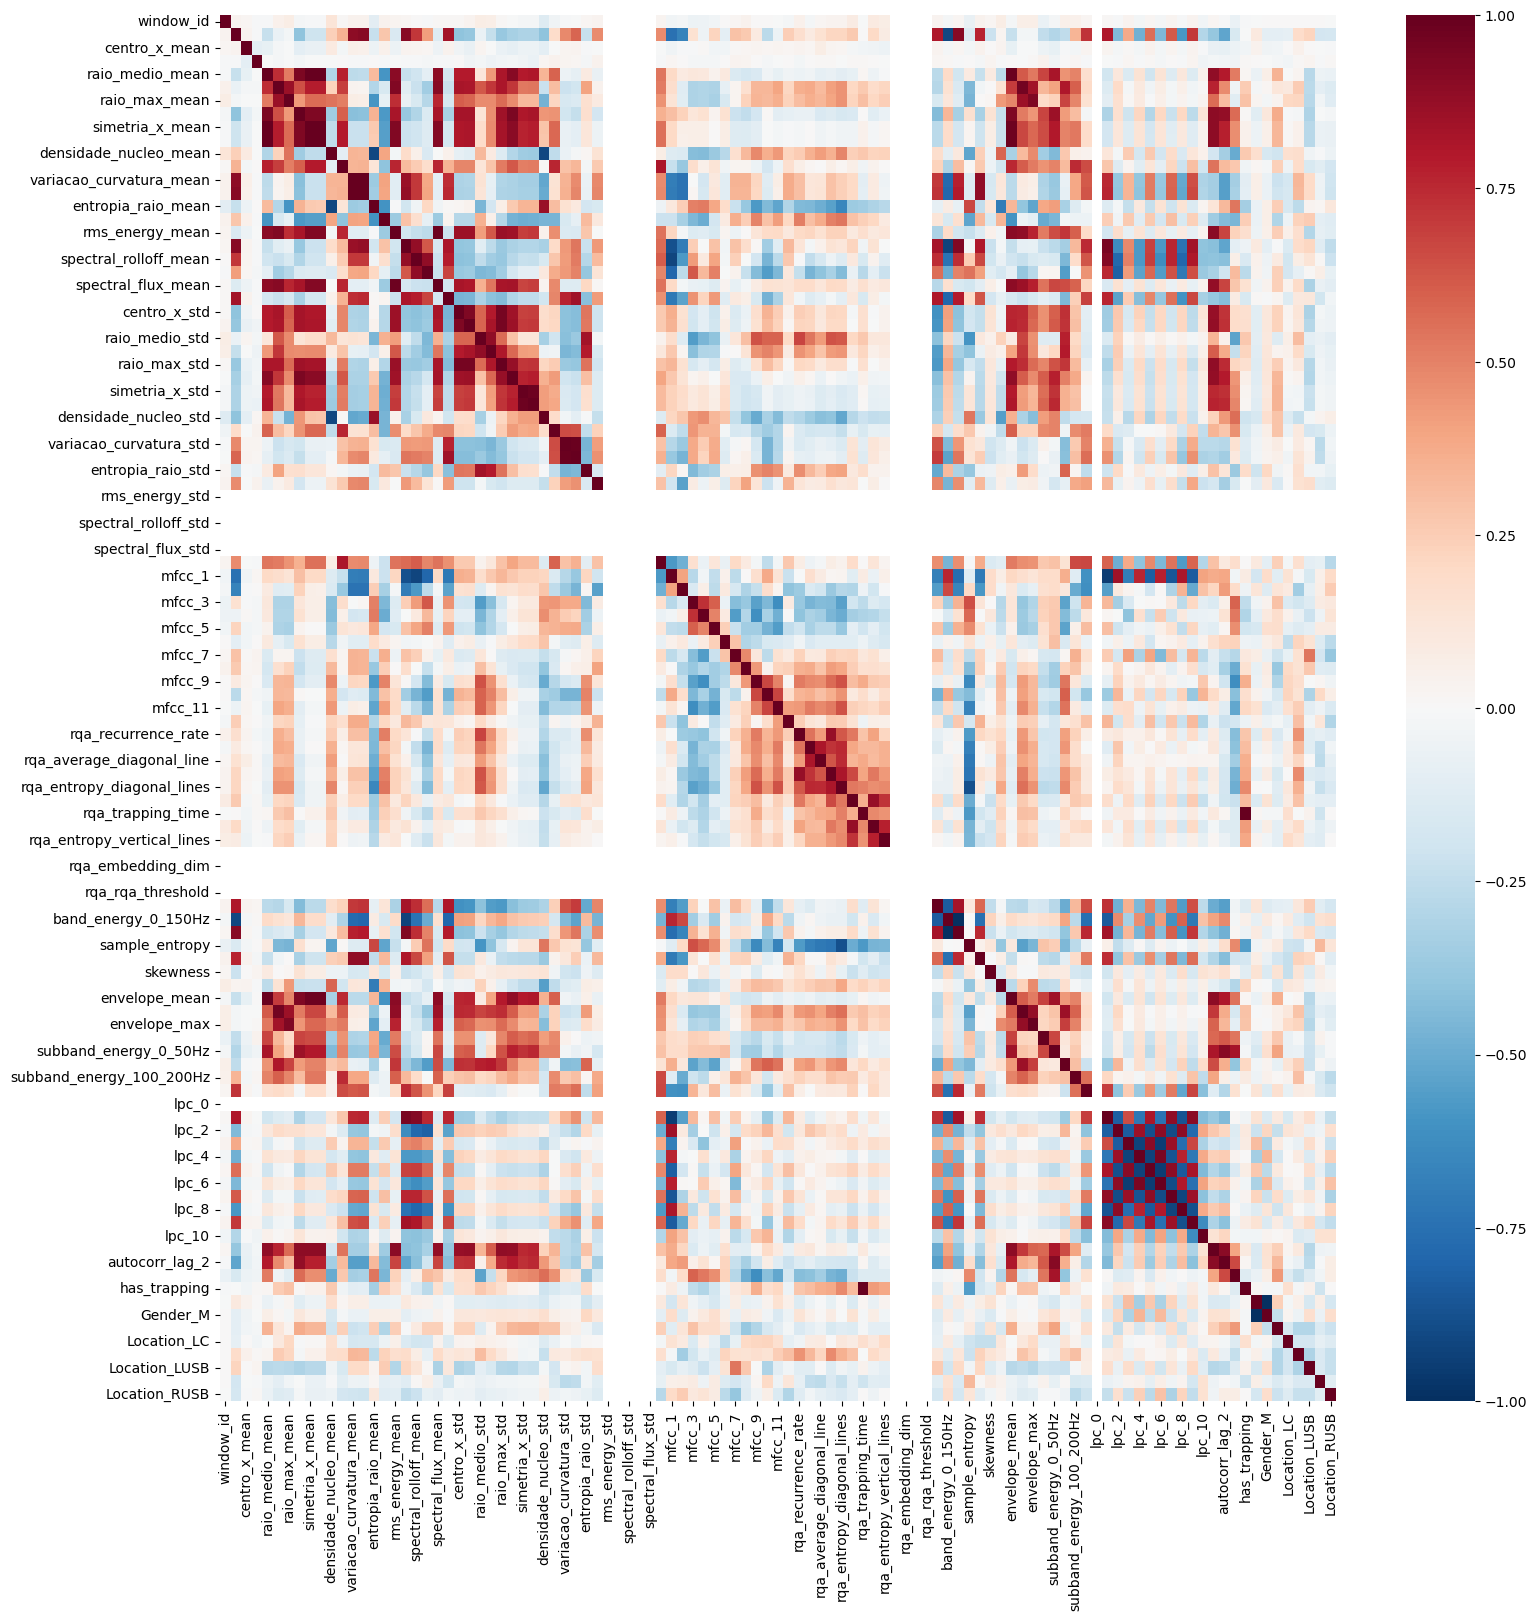

In [27]:

fig, ax = plt.subplots(figsize=(18,18))

ax = sns.heatmap(X_train.corr(),
             fmt='.2f',
             ax=ax,
             cmap="RdBu_r",
             vmin=-1,
             vmax=1,)
#sns.heatmap(X_train.corr())

O heatmap mostra claramente a existência de multicolinearidade, ou seja, grupos de features que estão fortemente correlacionadas entre si.

Manter features altamente correlacionadas é problemático por algumas razões:

- Redundância: O modelo não aprende nada de novo. Se duas features são 95% correlacionadas, elas estão essencialmente dizendo a mesma coisa.
- Instabilidade do Modelo: Alguns algoritmos (como regressões lineares) podem se tornar instáveis. Modelos de árvore (como o Random Forest) são mais robustos a isso, mas a redundância pode enviesar a interpretação da "importância das features".
- Maldição da Dimensionalidade: Manter features desnecessárias aumenta a complexidade do problema sem adicionar informação útil, podendo até piorar a performance do modelo.



In [37]:
# corr_matrix = X_train.corr().abs()

# upper_triangle = corr_matrix.where( # selecionando o triangulo superior para evitar duplicidades
#     np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# threshold = 0.85
# to_drop = [column for column in upper_triangle.columns if any(
#     upper_triangle[column] > threshold)]

# print(f"Número de features a serem removidas: {len(to_drop)}")
# print("Features sugeridas para remoção:")
# print(to_drop)

# X_train_reduced = X_train.drop(columns=to_drop)
# X_test_reduced = X_test.drop(columns=to_drop)

import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Passo 1: calcular a matriz de correlação
corr_matrix = X_train.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Passo 2: calcular a importância de cada feature com o target
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns)

# Passo 3: definir threshold e comparar importâncias
threshold = 0.85
to_drop = []

for col in upper_triangle.columns:
    for row in upper_triangle.index:
        if upper_triangle.loc[row, col] > threshold:
            # Comparar importâncias: dropa a menos relevante
            if mi_series[row] < mi_series[col]:
                to_drop.append(row)
            else:
                to_drop.append(col)

# Passo 4: remover duplicatas da lista
to_drop = list(set(to_drop))

# Passo 5: aplicar remoção nas bases
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test.drop(columns=to_drop)

# Logs
print(
    f"Número de features removidas com critério de utilidade: {len(to_drop)}")
print("Features removidas:", to_drop)

Número de features removidas com critério de utilidade: 41
Features removidas: ['spectral_flux_mean', 'subband_energy_0_50Hz', 'simetria_y_std', 'variacao_curvatura_std', 'raio_std_mean', 'simetria_y_mean', 'envelope_mean', 'rms_energy_mean', 'raio_min_mean', 'lpc_4', 'mfcc_1', 'rqa_laminarity', 'lpc_9', 'lpc_7', 'densidade_nucleo_mean', 'autocorr_lag_1', 'mudanca_media_direcao_mean', 'Gender_F', 'lpc_2', 'lpc_5', 'has_trapping', 'raio_max_std', 'rqa_entropy_diagonal_lines', 'raio_medio_mean', 'rqa_longest_diagonal_line', 'spectral_bandwidth_mean', 'band_energy_150_400Hz', 'spectral_rolloff_mean', 'simetria_x_mean', 'freq_mean', 'variacao_curvatura_mean', 'raio_std_std', 'centro_x_std', 'raio_max_mean', 'lpc_6', 'lpc_8', 'envelope_std', 'entropia_raio_mean', 'raio_min_std', 'centro_y_std', 'spectral_centroid_mean']


<Axes: >

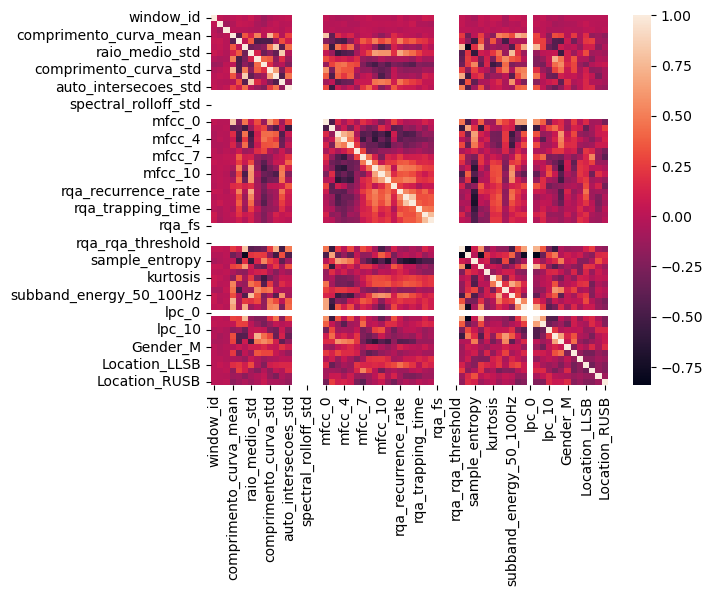

In [38]:
sns.heatmap(X_train_reduced.corr())

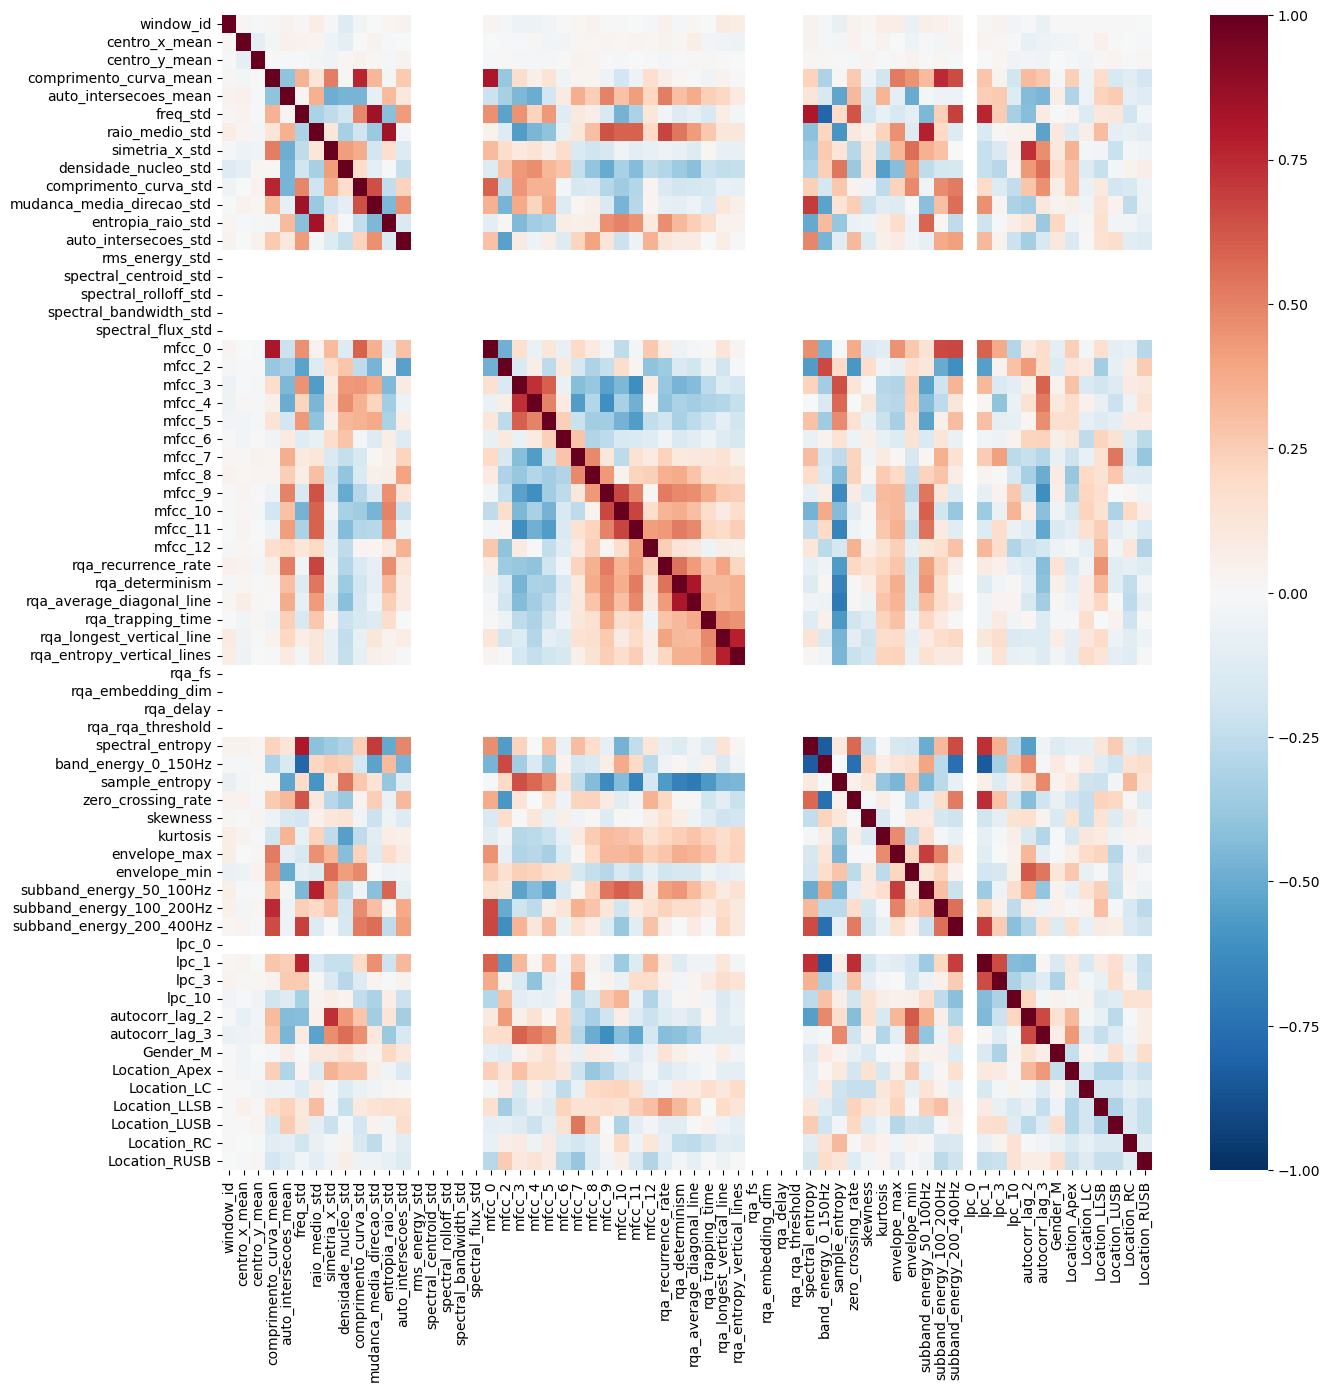

In [39]:

fig, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(X_train_reduced.corr(),
                 fmt='.2f',
                 ax=ax,
                 cmap="RdBu_r",
                 vmin=-1,
                 vmax=1,)
# sns.heatmap(X_train.corr())

### 3.2 Visualização da Distribuição por Classe

Para as features mais promissoras, é interessante criar gráficos que mostrem a distribuição dos valores para a classe Normal vs. Anormal. Se as distribuições forem bem diferentes, a feature é um bom preditor.

--- RANKING DE FEATURES POR PODER PREDITIVO (INFORMAÇÃO MÚTUA) ---
envelope_max                0.231830
lpc_1                       0.138320
band_energy_0_150Hz         0.115446
subband_energy_200_400Hz    0.109309
mfcc_3                      0.094731
                              ...   
spectral_rolloff_std        0.000000
window_id                   0.000000
rqa_fs                      0.000000
lpc_0                       0.000000
Location_Apex               0.000000
Name: MI Scores, Length: 64, dtype: float64


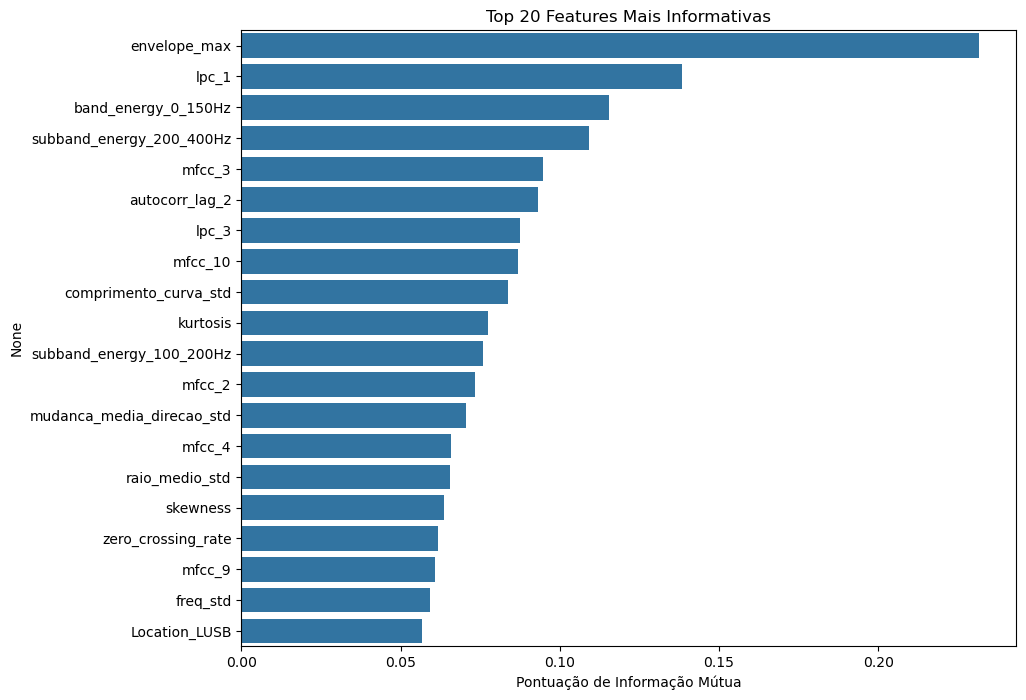

In [42]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_reduced, y_train, random_state=42)

mi_scores_series = pd.Series(
    mi_scores, index=X_train_reduced.columns, name="MI Scores")

mi_scores_series = mi_scores_series.sort_values(ascending=False)

print("--- RANKING DE FEATURES POR PODER PREDITIVO (INFORMAÇÃO MÚTUA) ---")
print(mi_scores_series)

n_feats = 20
plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores_series.head(n_feats), y=mi_scores_series.head(n_feats).index)
plt.title(f'Top {n_feats} Features Mais Informativas')
plt.xlabel('Pontuação de Informação Mútua')
plt.show()

In [45]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Carregar o dataset reduzido usado na etapa anterior
df = data

# Separar features e target
X = df.drop(columns=["Heart Sound Type_Abnormal", "Heart Sound ID"])
y = df["Heart Sound Type_Abnormal"]  # 1 para abnormal, 0 para normal

# Verificar se há NaNs
X = X.dropna(axis=1)

# Pipeline: padronização + seleção das 15 melhores features + Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=mutual_info_classif, k=15)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

# Exibir resultado
scores.mean(), scores.std()

(np.float64(0.97), np.float64(0.01341640786499875))

AVISO: Não foi possível calcular o KDE para 'rqa_delay_mean'.
AVISO: Não foi possível calcular o KDE para 'rms_energy_std'.


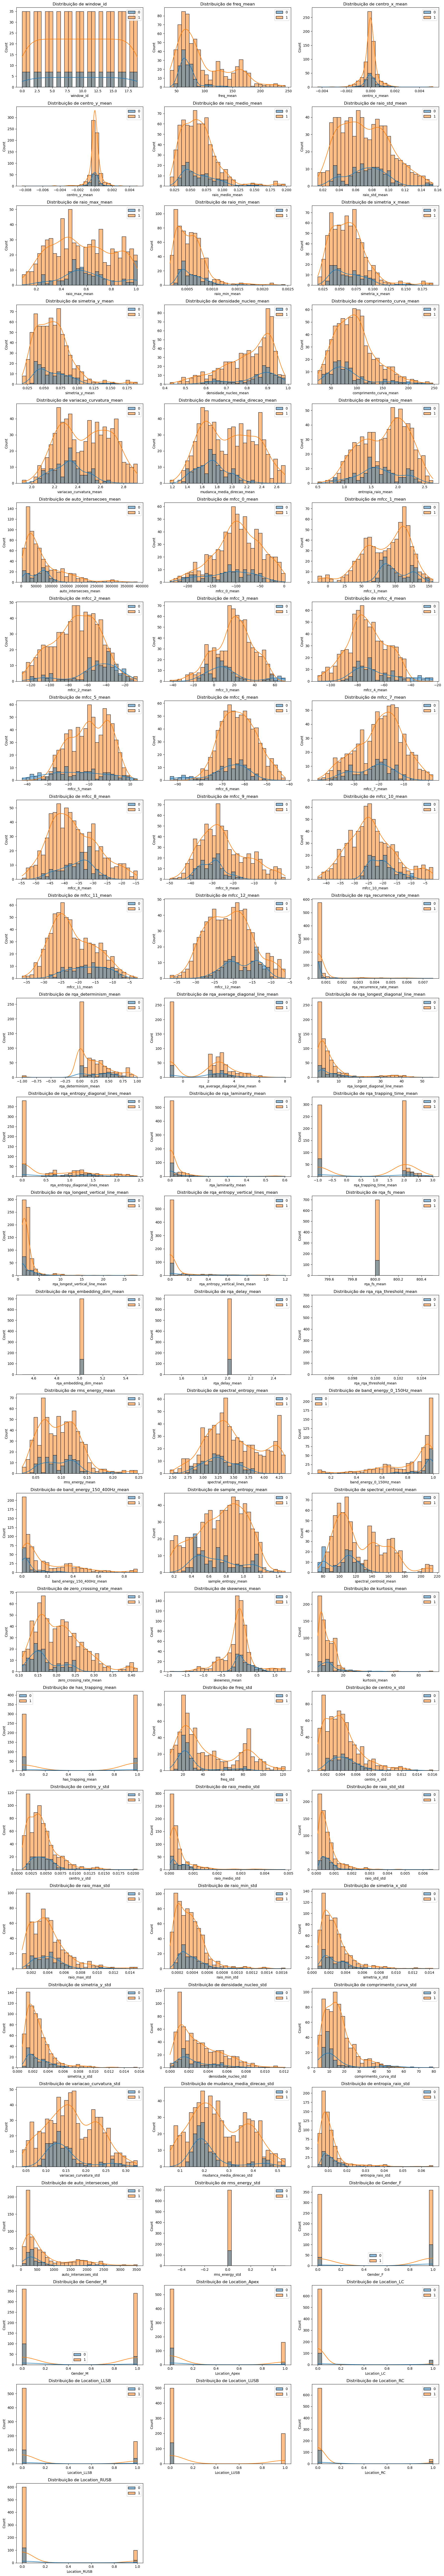

In [118]:

import math  

plot_df = X_train.join(y_train)
target_column_name = y_train.name

numeric_cols = X_train.select_dtypes(include=np.number).columns
n_features = len(numeric_cols)

ncols = 3  
nrows = math.ceil(n_features / ncols) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(ncols * 6, nrows * 4))

axes = axes.flatten()

for i, column in enumerate(numeric_cols):
    ax = axes[i]  

    try:
        sns.histplot(data=plot_df, x=column,
                     hue=target_column_name, kde=True, bins=30, ax=ax)
    except LinAlgError:
        print(f"AVISO: Não foi possível calcular o KDE para '{column}'.")
        sns.histplot(data=plot_df, x=column,
                     hue=target_column_name, kde=False, bins=30, ax=ax)

    ax.set_title(f'Distribuição de {column}', fontsize=12)
    ax.legend_.set_title(None)  

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.grid(True)
plt.show()

<Axes: xlabel='centro_x_mean', ylabel='Count'>

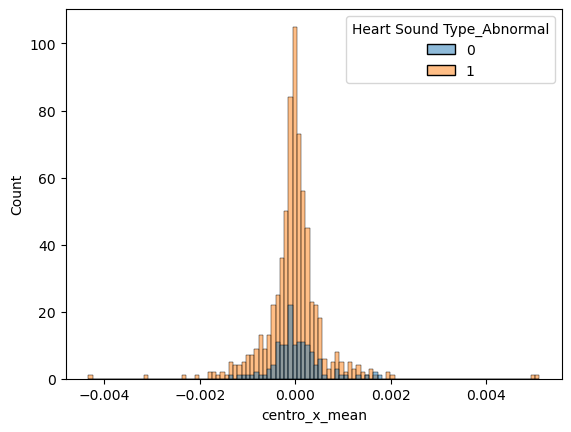

In [95]:
sns.histplot(data=X_train_reduced.join(y_train),
             x='centro_x_mean', hue='Heart Sound Type_Abnormal')

In [15]:

ids_normal = data[data['Heart Sound Type_Normal']
                  == 1]['Heart Sound ID'].unique()
ids_abnormal = data[data['Heart Sound Type_Normal']
                    == 0]['Heart Sound ID'].unique()

print("Normal IDs:", len(ids_normal))
print("Abnormal IDs:", len(ids_abnormal))

n_ids = min(len(ids_normal), len(ids_abnormal))

ids_normal_sampled = resample(
    ids_normal, replace=False, n_samples=n_ids, random_state=42)
ids_abnormal_sampled = resample(
    ids_abnormal, replace=False, n_samples=n_ids, random_state=42)

df_normal_down = data[data['Heart Sound ID'].isin(ids_normal_sampled)]
df_abnormal_down = data[data['Heart Sound ID'].isin(ids_abnormal_sampled)]

df_balanceado = pd.concat([df_normal_down, df_abnormal_down]).sample(
    frac=1, random_state=42)

print(df_balanceado['Heart Sound Type_Normal'].value_counts())
print("IDs únicos:", df_balanceado['Heart Sound ID'].nunique())

Normal IDs: 5
Abnormal IDs: 25
Heart Sound Type_Normal
1    100
0    100
Name: count, dtype: int64
IDs únicos: 10


## - Exploração

### Describe Variables

Calcular estatísticas descritivas básicas (`count`, `mean`, `std`, `min`, `25%`, `50%`, `75%`, `max`) para todas as colunas numéricas.

"Quais variáveis mais variam entre as janelas?"

In [41]:
data.info()
del data['Heart Sound ID']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Heart Sound ID                   600 non-null    object 
 1   window_id                        600 non-null    int64  
 2   freq_mean                        600 non-null    float64
 3   centro_x_mean                    600 non-null    float64
 4   centro_y_mean                    600 non-null    float64
 5   raio_medio_mean                  600 non-null    float64
 6   raio_std_mean                    600 non-null    float64
 7   raio_max_mean                    600 non-null    float64
 8   raio_min_mean                    600 non-null    float64
 9   simetria_x_mean                  600 non-null    float64
 10  simetria_y_mean                  600 non-null    float64
 11  densidade_nucleo_mean            600 non-null    float64
 12  comprimento_curva_mean

In [42]:
desc = data.describe().T.sort_values("std", ascending=False)
desc

count          mean           std          min  \
auto_intersecoes_mean   600.0  68469.684504  1.131164e+05  3591.981481   
auto_intersecoes_std    600.0    727.363482  8.279707e+02    40.847698   
mfcc_0_mean             600.0   -103.157517  5.329197e+01  -326.816616   
comprimento_curva_mean  600.0     97.550976  4.182367e+01     6.669564   
freq_mean               600.0     87.336991  3.721410e+01    37.388393   
...                       ...           ...           ...          ...   
rqa_rqa_threshold_mean  600.0      0.100000  9.769430e-16     0.100000   
rqa_embedding_dim_mean  600.0      5.000000  0.000000e+00     5.000000   
rqa_fs_mean             600.0    800.000000  0.000000e+00   800.000000   
rqa_delay_mean          600.0      2.000000  0.000000e+00     2.000000   
rms_energy_std          600.0      0.000000  0.000000e+00     0.000000   

                                 25%           50%           75%           max  
auto_intersecoes_mean   24532.081357  43168.969737  68541.591611  1.078025e+06  
auto_intersecoes_std      223.829637    302.310003    750.278057  3.572562e+03  
mfcc_0_mean              -126.091467    -99.952397    -76.057449 -2.109173e+00  
comprimento_curva_mean     69.925640     87.720155    116.699732  2.475706e+02  
freq_mean                  62.002366     74.353056    110.048718  1.970731e+02  
...                              ...           ...           ...           ...  
rqa_rqa_threshold_mean      0.100000      0.100000      0.100000  1.000000e-01  
rqa_embedding_dim_mean      5.000000      5.000000      5.000000  5.000000e+00  
rqa_fs_mean               800.000000    800.000000    800.000000  8.000000e+02  
rqa_delay_mean              2.000000      2.000000      2.000000  2.000000e+00  
rms_energy_std              0.000000      0.000000      0.000000  0.000000e+00  

[78 rows x 8 columns]

Variáveis com maior variabilidade (alto desvio padrão (`std`))

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `auto_intersecoes_mean`  | Varia muito de janela pra janela → sinal de **alta complexidade geométrica**          |
| `mfcc_0_mean`            | É a energia espectral global (1º coef. cepstral) → **bom sinal** que ele varia        |
| `comprimento_curva_mean` | Relacionado a densidade da winding → diferencia sons mais “longos” ou “curtos”        |
| `freq_mean`              | Frequência dominante média da janela → variação natural esperada em sons fisiológicos |

Ou seja, essas são as _features_  mais "vivas" do nosso dataset, as que provavelmente poderão ajudar os modelos a distinguir entre as classes.

Enquanto isso, as _features_ com menos variabilidade (desvio padrão (`std=0`)) são 

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `rqa_fs_mean	`           | Pois tem o valor fixo de 800. Taxa de amostragem usada no RQA, é esperada como constante         |
| `rqa_delay_mean`         | Valor fixo  =  2. Delay usado no embedding, fixado como hiperparâmetro, normal       |
| `rqa_embedding_dim_mean` | Dimensão do embedding, também fixada no código, esperado        |
| `rms_energy_std`         | Porque a energia já foi calculada uma única vez por janela.|

Ou seja, nenhuma dessas colunas com variabilidade nula apresentam alguma inconsistência até então, mas não são informativas para modelos de aprendizado supervisionado por não terem variação e não contribuirem para separação de classes.



In [43]:
columns_to_remove = ['rqa_fs_mean', 
                             'rqa_delay_mean', 
                             'rqa_embedding_dim_mean', 
                             'rms_energy_std', 
                             'Gender_M']
data = data.drop(columns=columns_to_remove)

### ANOVA entre classes (usando argmax da codificação one-hot como label)

ANOVA - Analysis of Variance

Um teste estatístico que responde à pergunta:

“Essa variável é diferente entre os grupos (classes) ou não?”

In [44]:
anova_binaria = {}

y = data["Heart Sound Type_Normal"]

top_vars = desc.head(22).index.tolist()


for var in top_vars:
    grupo_normal = data[data["Heart Sound Type_Normal"] == 1][var].dropna()
    grupo_anormal = data[data["Heart Sound Type_Normal"] == 0][var].dropna()
    if len(grupo_normal) >= 2 and len(grupo_anormal) >= 2:
        try:
            pval = f_oneway(grupo_normal, grupo_anormal).pvalue
            anova_binaria[var] = pval
        except Exception as e:
            print(f"Erro com {var}: {e}")
    else:
        print(f"Variável ignorada: {var} (amostras insuficientes)")

# Ordena por p-valor (menor = mais discriminativo)
anova_binaria_sorted = dict(sorted(anova_binaria.items(), key=lambda x: x[1]))

In [45]:
anova_binaria_sorted

{'mfcc_11_mean': np.float64(5.437605647446237e-20),
 'mfcc_5_mean': np.float64(2.96932286321955e-13),
 'mfcc_6_mean': np.float64(3.1658276712921523e-12),
 'mfcc_10_mean': np.float64(5.981709426162654e-10),
 'mfcc_12_mean': np.float64(8.641415616517434e-10),
 'mfcc_2_mean': np.float64(2.241567779230638e-09),
 'mfcc_3_mean': np.float64(1.2256220999315055e-08),
 'spectral_centroid_mean': np.float64(2.747578054593789e-07),
 'freq_std': np.float64(4.519426275911533e-06),
 'freq_mean': np.float64(5.039997614192798e-05),
 'rqa_longest_diagonal_line_mean': np.float64(0.0020929396354588273),
 'mfcc_8_mean': np.float64(0.004228675269783627),
 'auto_intersecoes_std': np.float64(0.005769008520704557),
 'mfcc_1_mean': np.float64(0.031397223448434305),
 'kurtosis_mean': np.float64(0.04558969921192295),
 'mfcc_9_mean': np.float64(0.07157410017936437),
 'comprimento_curva_mean': np.float64(0.1455555736361532),
 'mfcc_0_mean': np.float64(0.23176025119754018),
 'auto_intersecoes_mean': np.float64(0.3936

### Correlograma das 22 principais variáveis

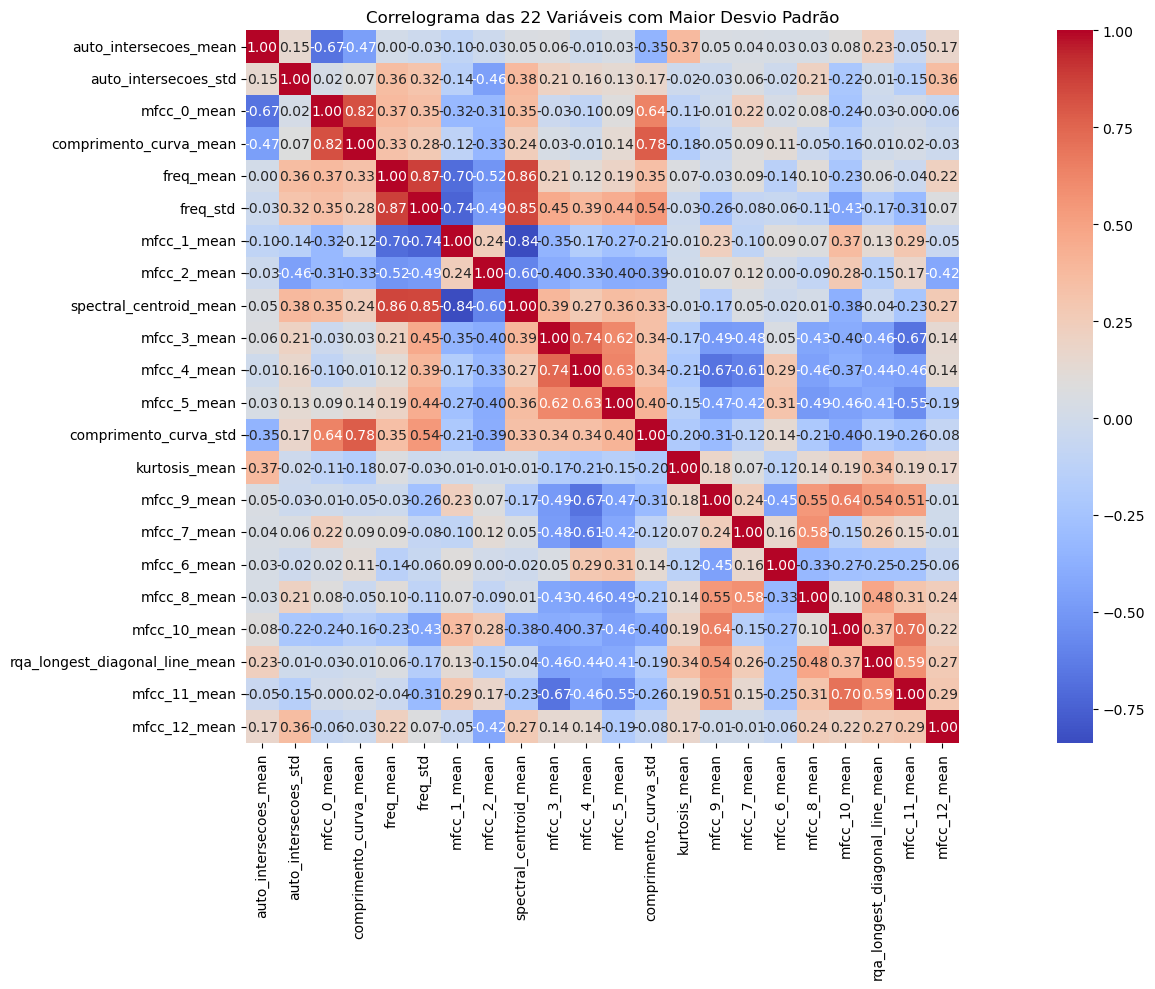

In [46]:
desc = data.describe().T.sort_values("std", ascending=False)
corr = data[top_vars].corr()

plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)

plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")

plt.tight_layout()

plt.show()

In [ ]:
data = data.drop(columns=['comprimento_curva_mean',
                          'freq_std', 
                          'rqa_trapping_time_mean'], errors='ignore')

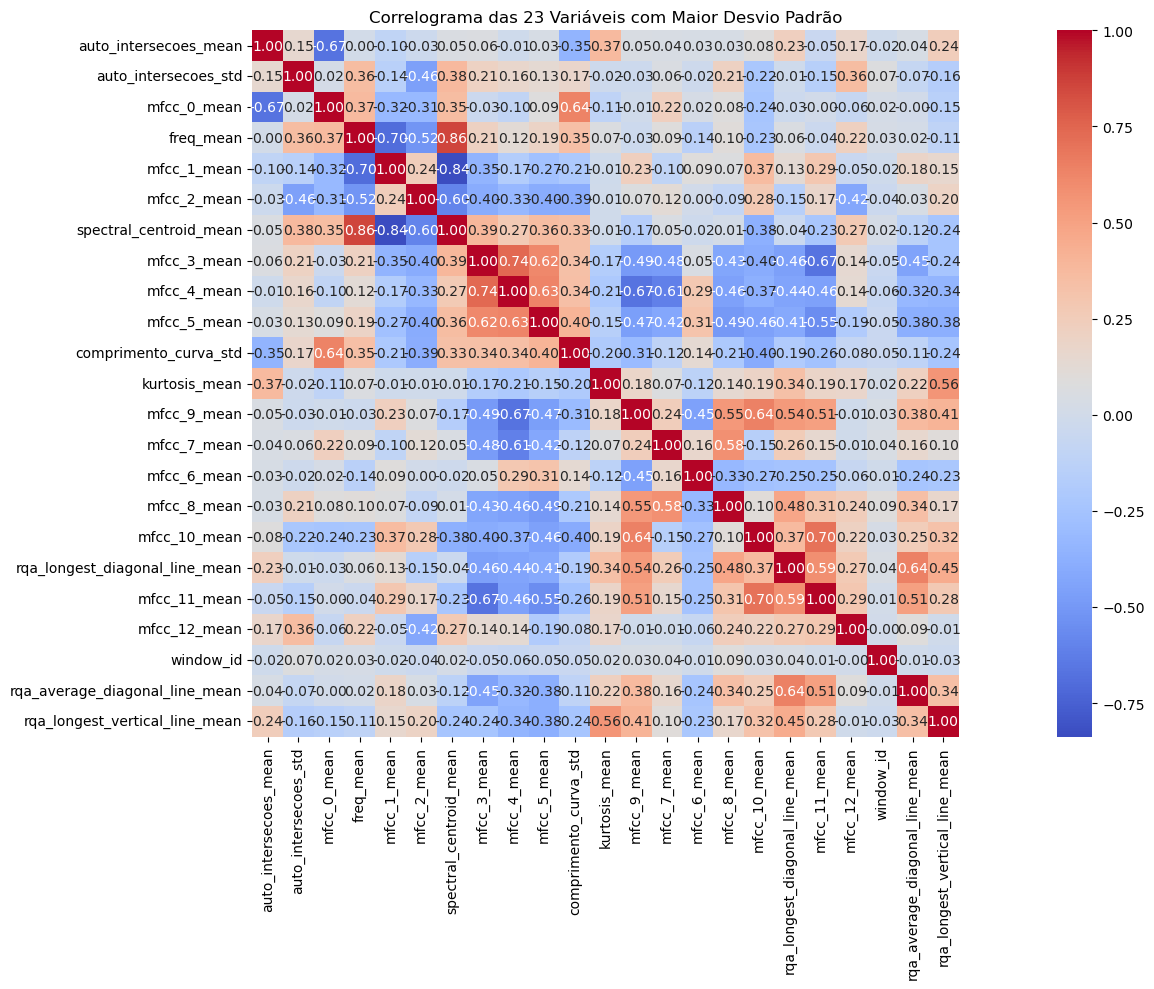

In [56]:
desc = data.describe().T.sort_values("std", ascending=False)
top_vars = desc.head(23).index.tolist()
corr = data[top_vars].corr()

plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)

plt.title("Correlograma das 23 Variáveis com Maior Desvio Padrão")

plt.tight_layout()

plt.show()

### Distribuição de classes no split fixo

In [ ]:
def plot_class_distribution(y, title):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Classe')
    plt.ylabel('Contagem')
    plt.show()

print("\nDistribuição de classes no split fixo")
plot_class_distribution(y_train_split, "Treino (Split Estratificado)")
plot_class_distribution(y_val_split, "Validação (Split Estratificado)")
plot_class_distribution(y_test_split, "Teste (Split Estratificado)")



Distribuição de classes no split fixo


ValueError: If using all scalar values, you must pass an index

### Distribuição de classes por fold


Distribuição de classes nos folds k-fold
Fold 1 - Treino


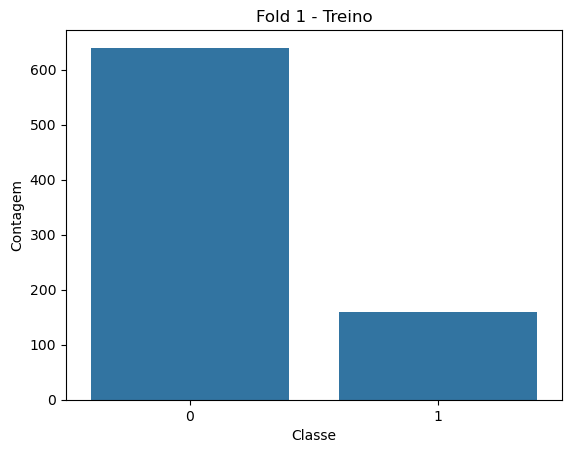

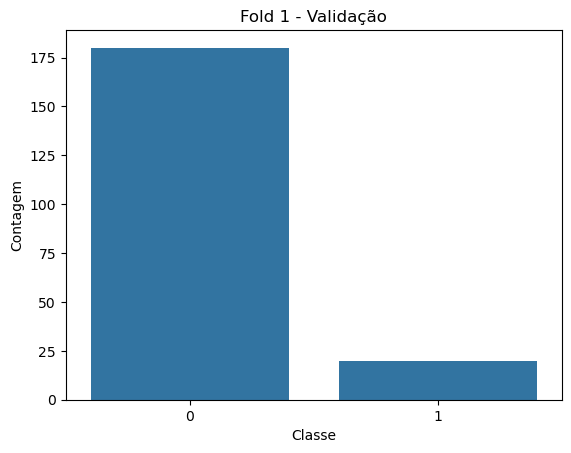

Fold 2 - Treino


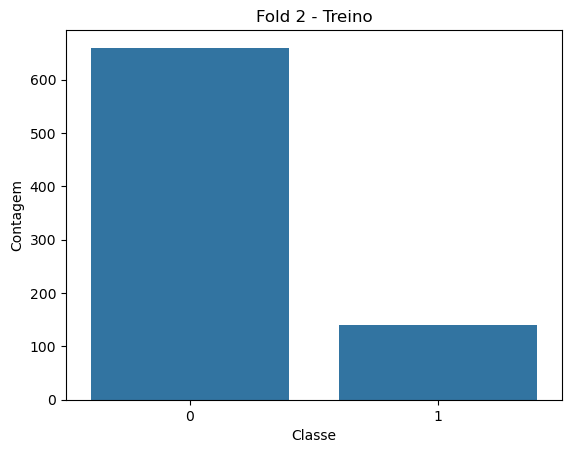

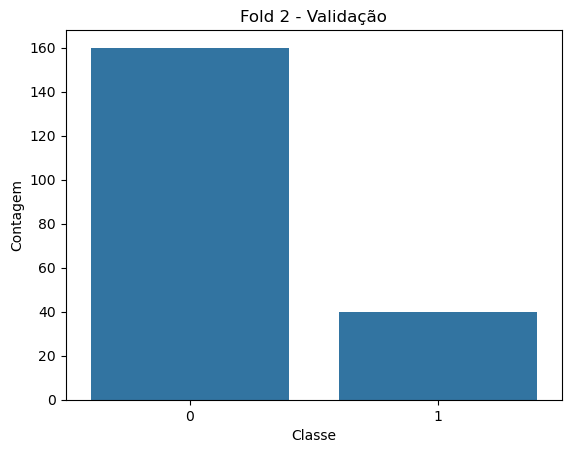

Fold 3 - Treino


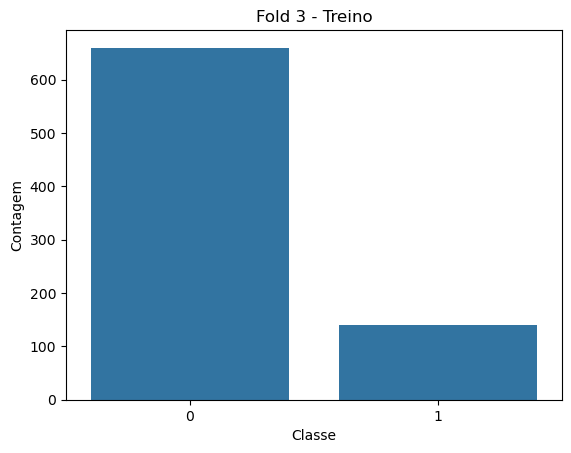

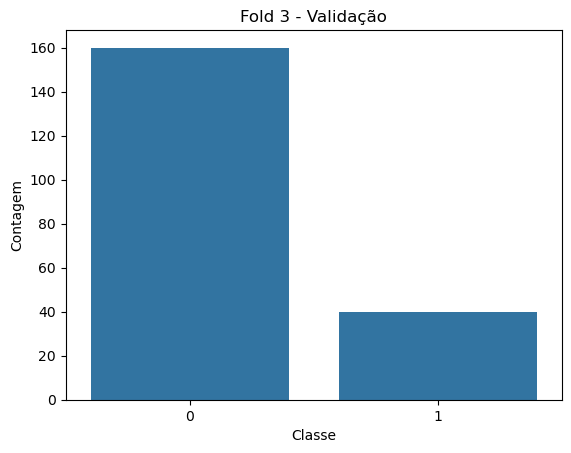

Fold 4 - Treino


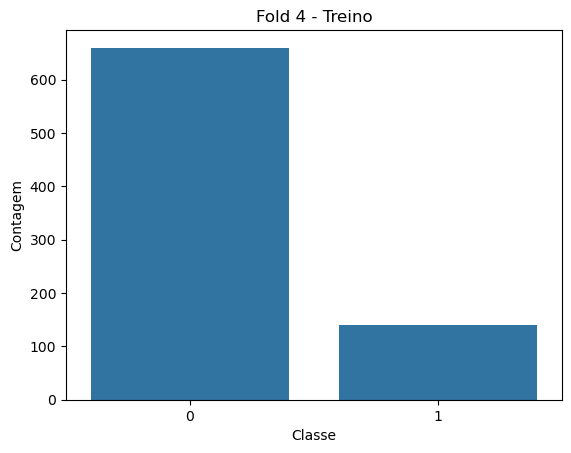

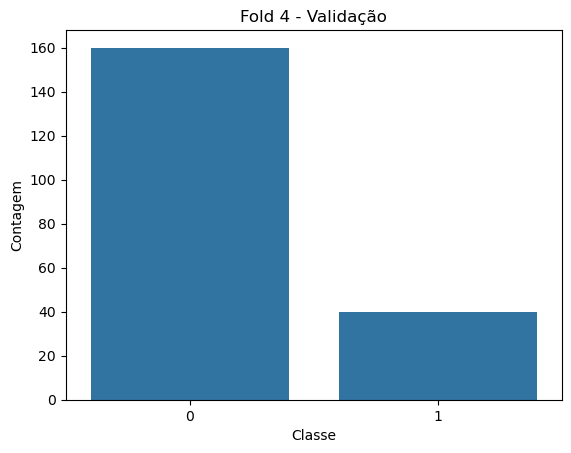

Fold 5 - Treino


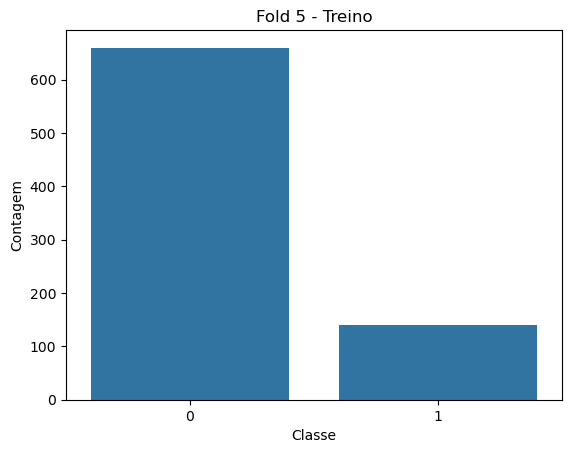

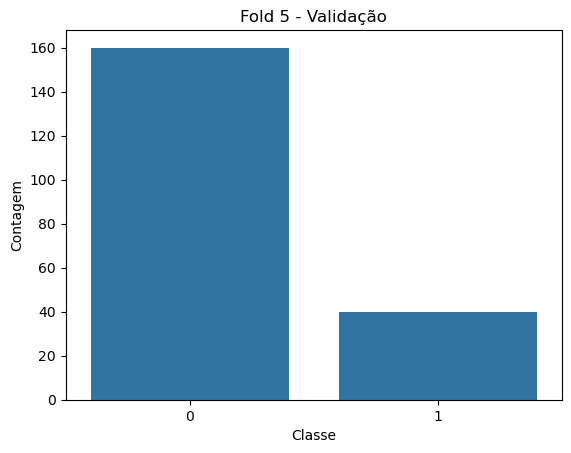

In [13]:
print("\nDistribuição de classes nos folds k-fold")
for fold in folds:
    print(f"Fold {fold['fold']} - Treino")
    plot_class_distribution(fold['y_train'], f"Fold {fold['fold']} - Treino")
    plot_class_distribution(fold['y_val'], f"Fold {fold['fold']} - Validação")

### **SEPARAÇÃO NÃO-LINEAR**

O PCA (Principal Component Analysis) reduz a dimensionalidade do dataset projetando os dados em componentes principais que preservam a **variância máxima**. É útil para visualizar a estrutura global dos dados. O t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica não-linear que foca em preservar **relações locais** entre os pontos. É mais adequado quando queremos identificar **aglomerados ou separações sutis** entre as classes.

#### PCA para visualização em 2D (split fixo)

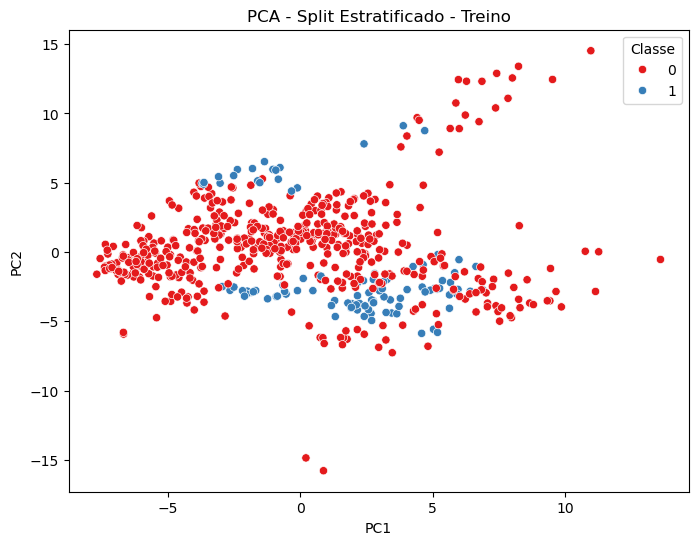

In [64]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_split_scaled)

plt.figure(figsize=(8, 6))
plt.title("PCA - Split Estratificado - Treino")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=y_train_split, palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Classe")
plt.show()

#### PCA por fold

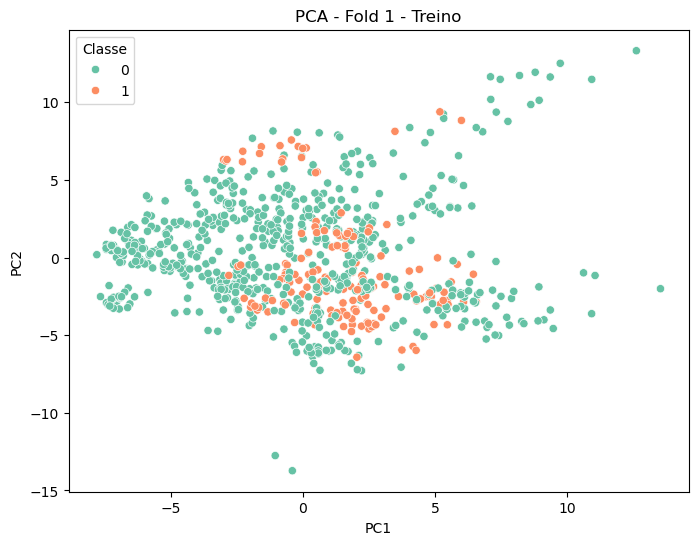

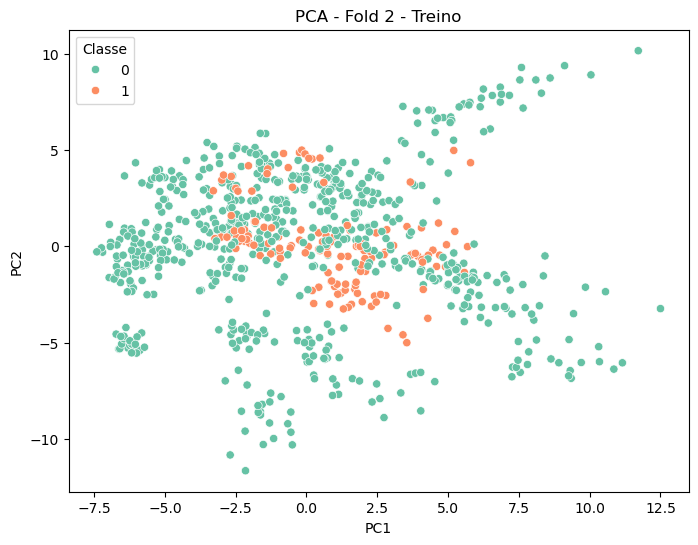

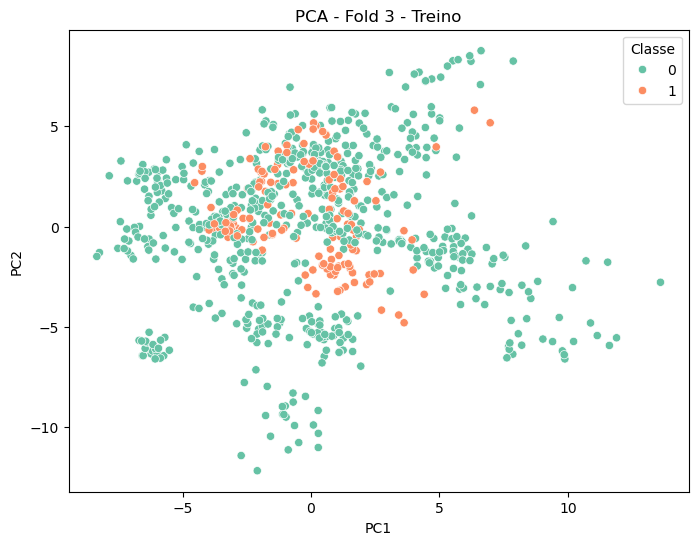

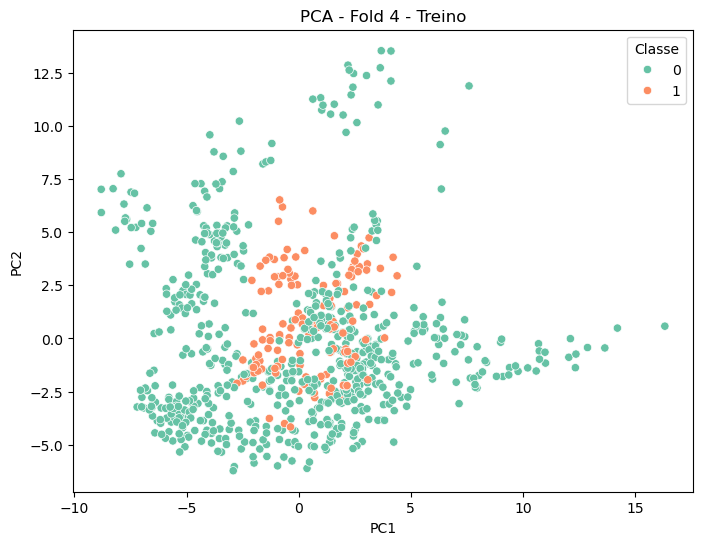

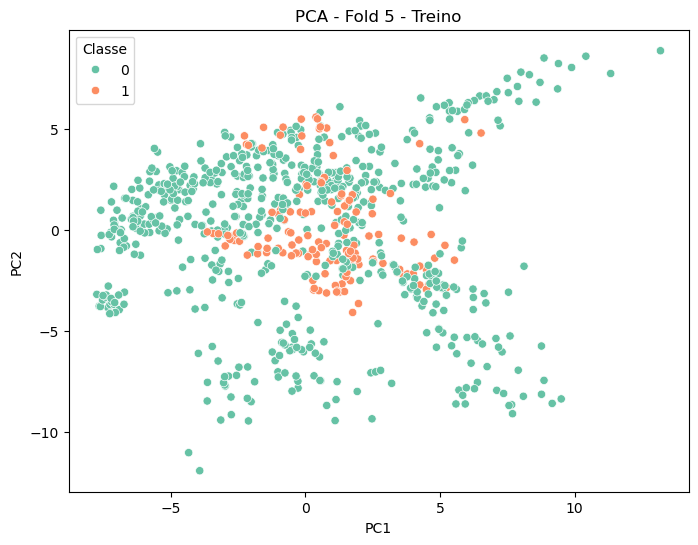

In [16]:
for fold in folds:
     Xf_pca = PCA(n_components=2).fit_transform(fold['X_train'])
     plt.figure(figsize=(8, 6))
     plt.title(f"PCA - Fold {fold['fold']} - Treino")
     sns.scatterplot(x=Xf_pca[:,0], y=Xf_pca[:,1], hue=fold['y_train'], palette="Set2")
     plt.xlabel("PC1")
     plt.ylabel("PC2")
     plt.legend(title="Classe")
     plt.show()


In [36]:
numeric_cols = df_train_split.select_dtypes(
    include=["float64", "int"]).columns.drop("window_id", errors="ignore")

X_scaled = StandardScaler().fit_transform(df_train_split[numeric_cols])

#### **UMAP e t-SNE para separação não-linear**

- O StandardScaler é aplicado para normalizar os dados antes da redução dimensional.

- Um PCA inicial com 30 componentes foi utilizado antes do t-SNE para reduzir ruído e acelerar o processo.

- O t-SNE foi aplicado com:

     - `n_components=2`: projetando os dados para duas dimensões.

     - `perplexity=30`: define o tamanho do “contexto” considerado localmente em torno de cada ponto (ajuste fino de agrupamentos).

t-SNE sem PCA pode se perder em ruído. PCA --> t-SNE é uma estratégia clássica para manter estrutura relevante e reduzir overfitting visual.

##### UMAP 2D (split fixo)

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



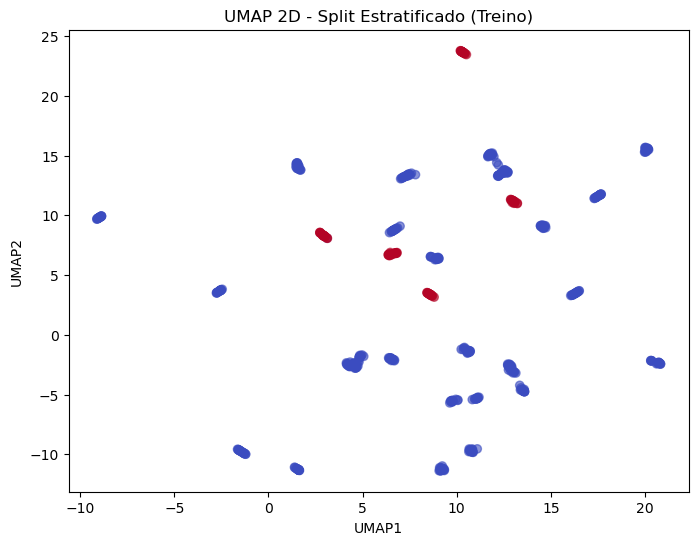

In [43]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.title("UMAP 2D - Split Estratificado (Treino)")
plt.scatter(X_umap[:, 0], X_umap[:, 1],
            c=y_train_split, cmap='coolwarm', alpha=0.6)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

##### UMAP 2D (por fold)

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



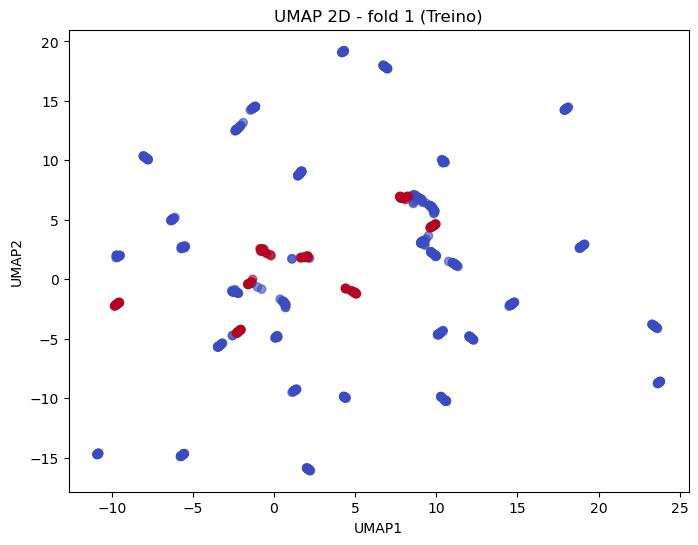

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



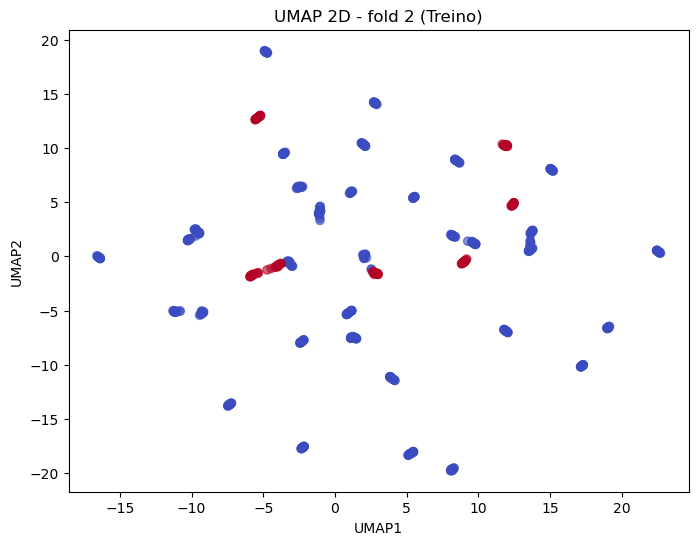

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



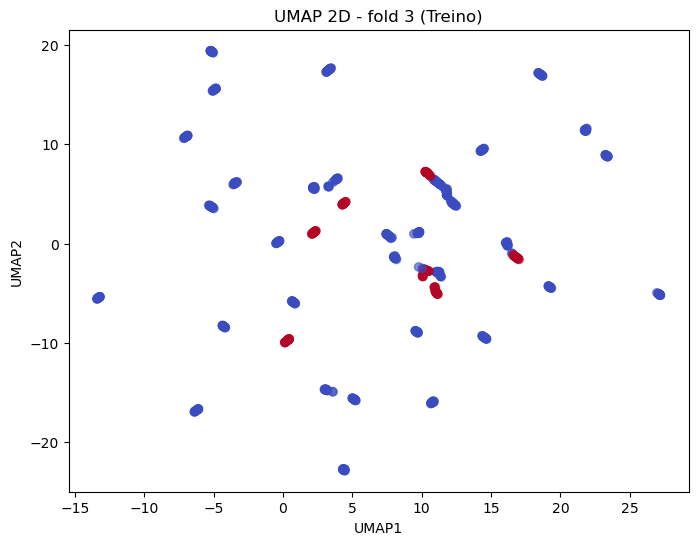

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



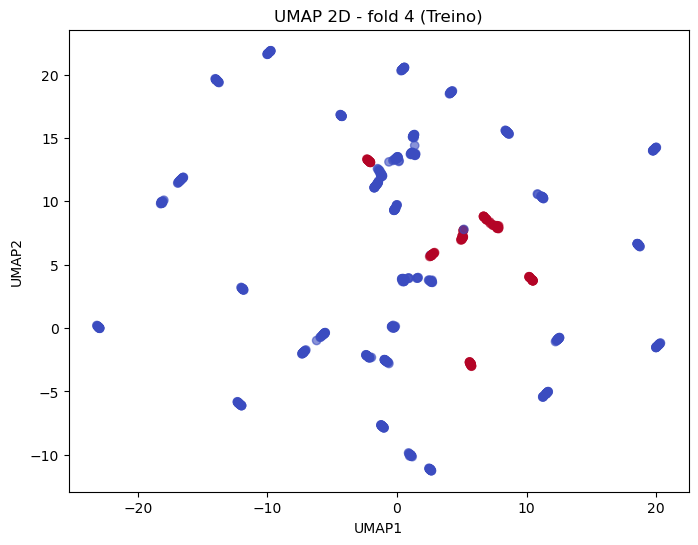

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



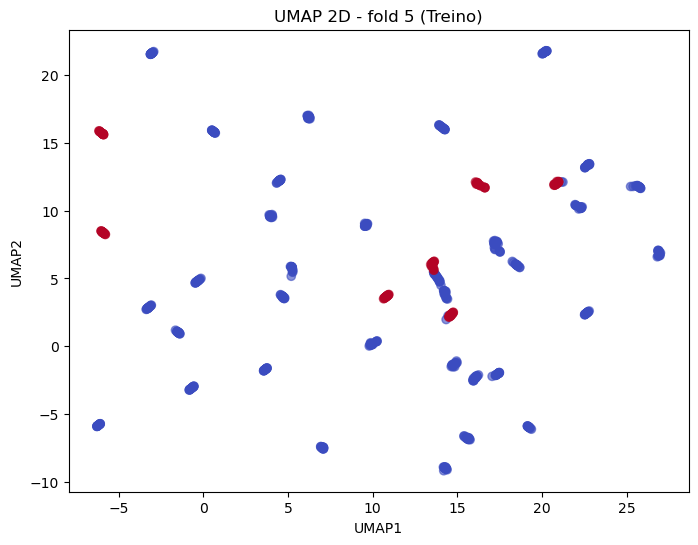

In [46]:
for fold in folds:
    Xf_umap = reducer.fit_transform(fold['X_train'])
    
    plt.figure(figsize=(8, 6))
    plt.title(f"UMAP 2D - fold {fold['fold']} (Treino)")
    plt.scatter(Xf_umap[:, 0], Xf_umap[:, 1],
                c=fold['y_train'], cmap='coolwarm', alpha=0.6)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.show()

##### t-SNE 2D (split fixo)

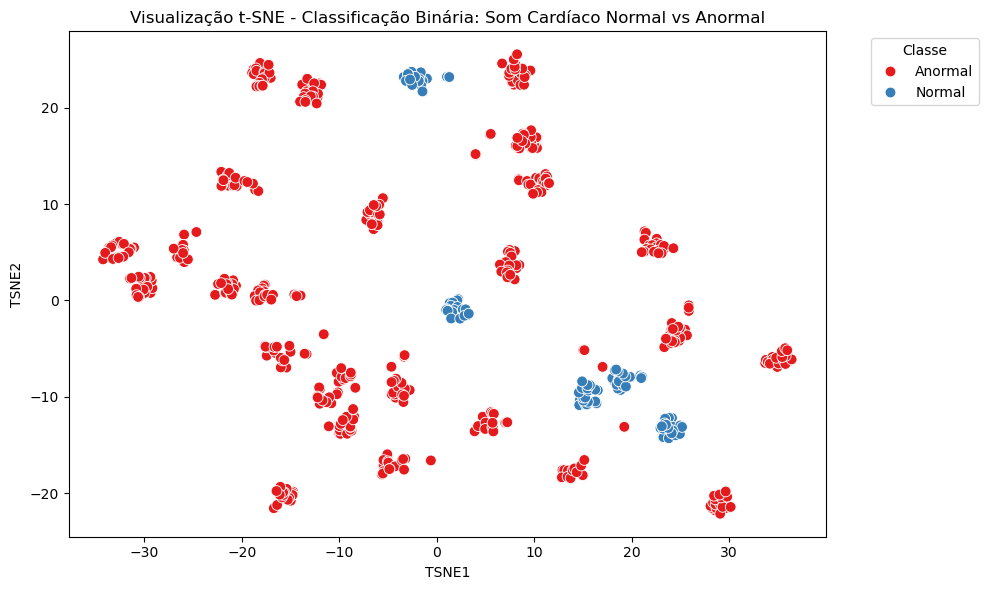

In [40]:
df = df_train_split.copy()

X = df.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")

if "Heart Sound Type_Normal" in df.columns:
    df["label"] = df["Heart Sound Type_Normal"].map(
        {0: "Anormal", 1: "Normal"})
    y = df["label"]
else:
    raise ValueError("Coluna 'Heart_Sound_Type_Normal' não encontrada.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Redução de dimensionalidade com PCA antes do t-SNE
pca = PCA(n_components=10)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_split_scaled)

df["TSNE1"] = X_tsne[:, 0]
df["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2",
                hue="label", palette="Set1", s=60)
plt.title(
    "Visualização t-SNE - Classificação Binária: Som Cardíaco Normal vs Anormal")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### t-SNE em 3D

In [ ]:

df = df_train_split.copy()

label_col = [c for c in df.columns if c.startswith("Heart Sound Type_")]
df["label"] = df[label_col].idxmax(axis=1)

# Separar features numéricas
X = df.select_dtypes(include="number").drop(
    columns=["window_id"], errors="ignore")
X = X.drop(columns=label_col, errors="ignore")

# Normalização
X_scaled = StandardScaler().fit_transform(X)

# t-SNE em 3D
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df["tsne_1"] = X_tsne[:, 0]
df["tsne_2"] = X_tsne[:, 1]
df["tsne_3"] = X_tsne[:, 2]

fig = px.scatter_3d(df, x="tsne_1", y="tsne_2", z="tsne_3", color="label",
                    title="t-SNE (3D) - Separação por tipo de som cardíaco",
                    opacity=0.8)
fig.show()

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
df_train_split = df_train_split.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std' ], errors='ignore')

df_train_split_scaled = df_train_split_scaled.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std'], errors='ignore')

In [52]:
df_train_split.columns

Index(['Heart Sound ID', 'window_id', 'freq_mean', 'centro_x_mean',
       'centro_y_mean', 'raio_medio_mean', 'raio_std_mean', 'raio_max_mean',
       'raio_min_mean', 'simetria_x_mean', 'simetria_y_mean',
       'densidade_nucleo_mean', 'comprimento_curva_mean',
       'variacao_curvatura_mean', 'mudanca_media_direcao_mean',
       'entropia_raio_mean', 'auto_intersecoes_mean', 'mfcc_0_mean',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'rqa_recurrence_rate_mean', 'rqa_determinism_mean',
       'rqa_average_diagonal_line_mean', 'rqa_longest_diagonal_line_mean',
       'rqa_entropy_diagonal_lines_mean', 'rqa_laminarity_mean',
       'rqa_trapping_time_mean', 'rqa_longest_vertical_line_mean',
       'rqa_entropy_vertical_lines_mean', 'rqa_fs_mean',
       'rqa_embedding_dim_mean', 'rqa_delay_mean', 'rqa_rqa_threshold_mean'

In [60]:
df = df_train_split.copy()
top_vars = desc.head(22).index.tolist()

anova_binaria = {}

y = df_train_split["Heart Sound Type_Normal"]

for var in top_vars:
    grupo_normal = df[df["Heart Sound Type_Normal"] == 1][var].dropna(
    )
    grupo_anormal = df[df["Heart Sound Type_Normal"]
                               == 0][var].dropna()

    if len(grupo_normal) >= 2 and len(grupo_anormal) >= 2:
        try:
            pval = f_oneway(grupo_normal, grupo_anormal).pvalue
            anova_binaria[var] = pval
        except Exception as e:
            print(f"Erro com {var}: {e}")
    else:
        print(f"Variável ignorada: {var} (amostras insuficientes)")

anova_binaria_sorted = dict(sorted(anova_binaria.items(), key=lambda x: x[1]))

In [61]:
anova_binaria_sorted

{'mfcc_11_mean': np.float64(5.437605647446237e-20),
 'mfcc_5_mean': np.float64(2.96932286321955e-13),
 'mfcc_6_mean': np.float64(3.1658276712921523e-12),
 'mfcc_10_mean': np.float64(5.981709426162654e-10),
 'mfcc_12_mean': np.float64(8.641415616517434e-10),
 'mfcc_2_mean': np.float64(2.241567779230638e-09),
 'mfcc_3_mean': np.float64(1.2256220999315055e-08),
 'spectral_centroid_mean': np.float64(2.747578054593789e-07),
 'freq_std': np.float64(4.519426275911533e-06),
 'freq_mean': np.float64(5.039997614192798e-05),
 'rqa_longest_diagonal_line_mean': np.float64(0.0020929396354588273),
 'mfcc_8_mean': np.float64(0.004228675269783627),
 'auto_intersecoes_std': np.float64(0.005769008520704557),
 'mfcc_1_mean': np.float64(0.031397223448434305),
 'kurtosis_mean': np.float64(0.04558969921192295),
 'mfcc_9_mean': np.float64(0.07157410017936437),
 'comprimento_curva_mean': np.float64(0.1455555736361532),
 'mfcc_0_mean': np.float64(0.23176025119754018),
 'auto_intersecoes_mean': np.float64(0.3936

In [24]:
del df_agg_cod['window_id']
del df_agg_cod_norm['window_id']

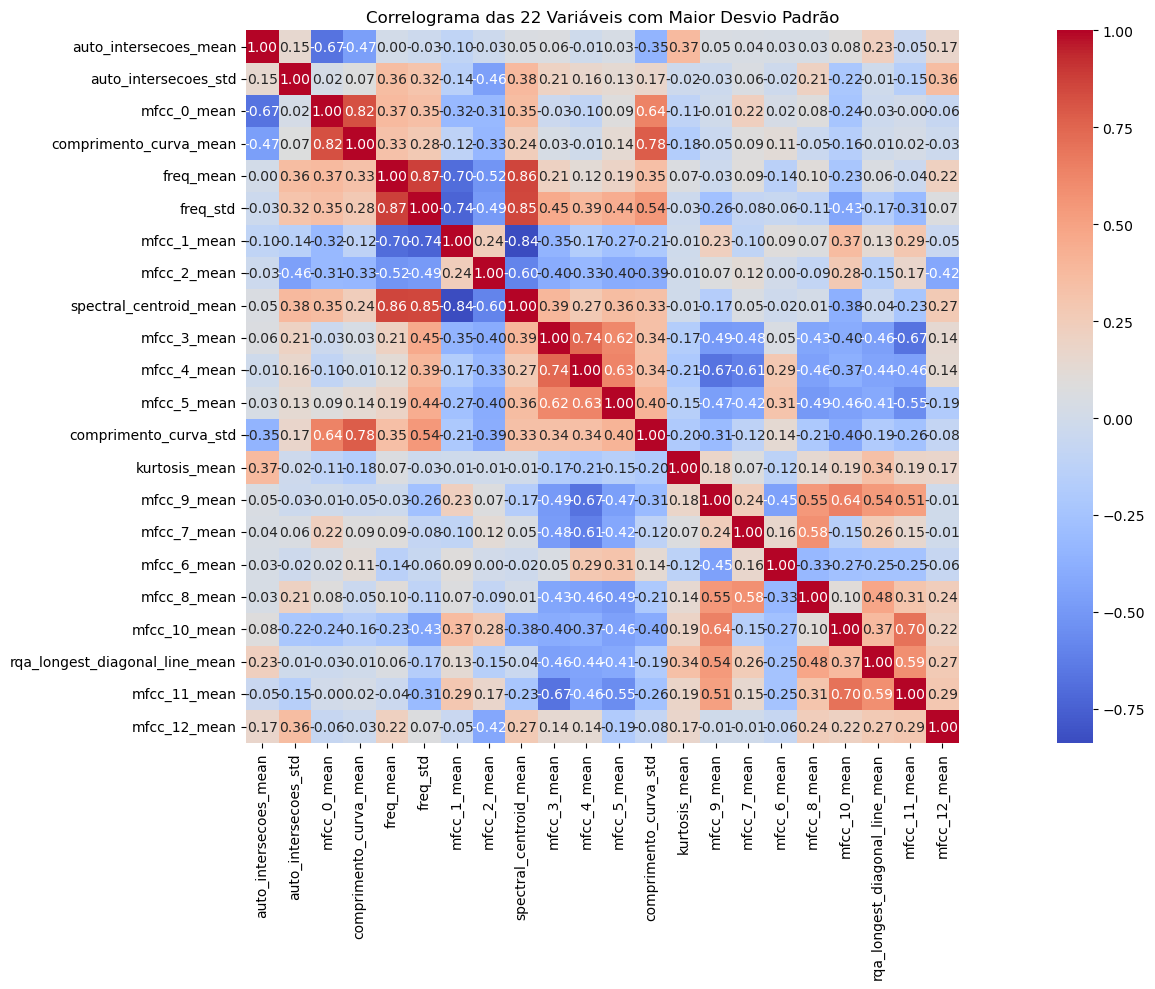

O Heatmap de correlação de Pearson entre as 22 variáveis com maior desvio padrão do dataset agregado por janela nos diz que há alta correlação (redundância potencial) entre:

* `mfcc_0_mean`:
     * `comprimento_curva_mean` (r=0.83)
     * `comprimento_curva_std` (r=0.61)

* `freq_mean`:
     * `freq_std` (r=0.77)
     * `spectral_centroid_mean` (r=0.92)

* `mfcc_3_mean`:
     * `mfcc_4_mean` (r=0.70)

* `mfcc_9_mean`:
     * `mfcc_10_mean` (r=0.65)


DECISÃO PROVISÓRIA: 
- deletar as _features_ de maior correlação com outras:


In [26]:
df_agg_cod = df_agg_cod.drop(
    columns=['freq_mean', 'comprimento_curva_mean', 'has_trapping_mean', 'freq_std'], errors='ignore')
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)

In [27]:
# Como Gender_M e Gender_F são inversamente correlacionados, é interessante deletar um desses atributos
del df_agg_cod['Gender_M']

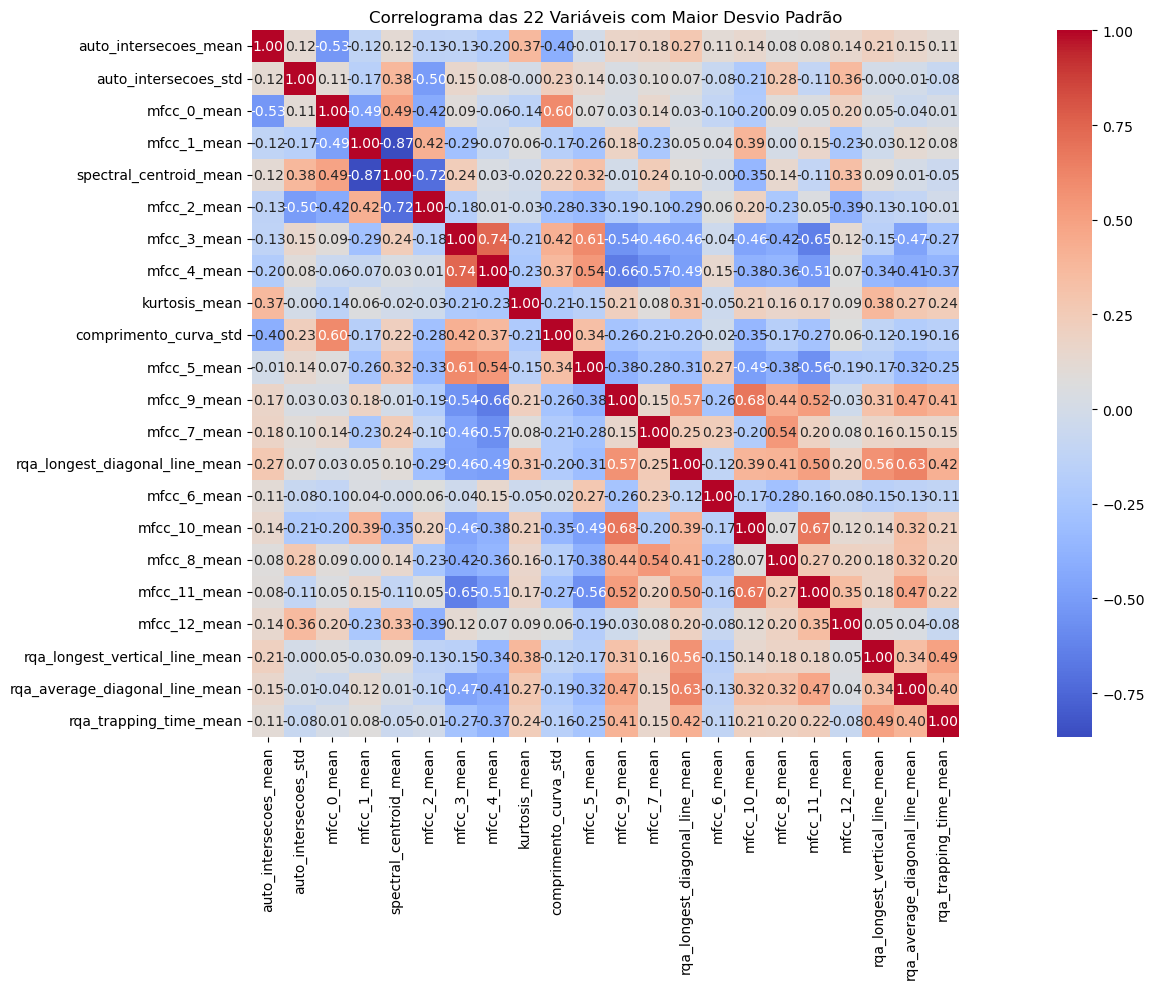

In [28]:
top_vars = desc.head(22).index.tolist()
corr = df_agg_cod[top_vars].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")
plt.tight_layout()
plt.show()

In [105]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Copiar base
# df_features = df_agg_cod.copy()

# # Identificar MFCCs
# mfcc_cols = [
#     col for col in df_features.columns if "mfcc_" in col and "_mean" in col]

# # OUTRA FEATURES: manter apenas colunas numéricas úteis (sem redundâncias e constantes)
# non_mfcc_cols = [
#     col for col in df_features.select_dtypes(include=["float64", "int"]).columns
#     if col not in mfcc_cols + ["window_id"] and not col.endswith("_std")
# ]

# # X_A: versão com MFCCs selecionados manualmente (os menos correlacionados)
# mfcc_selected = ["mfcc_0_mean", "mfcc_3_mean", "mfcc_9_mean"]
# X_A = df_features[mfcc_selected + non_mfcc_cols].copy()

# # X_B: versão com PCA nos MFCCs (3 componentes)
# scaler = StandardScaler()
# X_mfcc_scaled = scaler.fit_transform(df_features[mfcc_cols])
# pca = PCA(n_components=3)
# X_mfcc_pca = pca.fit_transform(X_mfcc_scaled)

# # Nomear colunas PCA
# df_pca_mfcc = pd.DataFrame(
#     X_mfcc_pca, columns=["mfcc_pca_1", "mfcc_pca_2", "mfcc_pca_3"])
# df_pca_mfcc.index = df_features.index  # garantir alinhamento

# X_B = pd.concat([df_pca_mfcc, df_features[non_mfcc_cols]], axis=1)
# del X_B['has_trapping_mean']
# del X_B['freq_mean']


In [25]:
del df_agg_cod['window_id']

p-valores extremamente baixos indicam que essas variáveis são **altamente relevantes para diferenciar entre classes** de sons cardíacos. Variáveis como MFCCs, auto-interseções e métricas RQA se destacam como mais informativas.

- O StandardScaler é aplicado para normalizar os dados antes da redução dimensional.

- Um PCA inicial com 30 componentes foi utilizado antes do t-SNE para reduzir ruído e acelerar o processo.

- O t-SNE foi aplicado com:

     - `n_components=2`: projetando os dados para duas dimensões.

     - `perplexity=30`: define o tamanho do “contexto” considerado localmente em torno de cada ponto (ajuste fino de agrupamentos).

t-SNE sem PCA pode se perder em ruído. PCA --> t-SNE é uma estratégia clássica para manter estrutura relevante e reduzir overfitting visual.

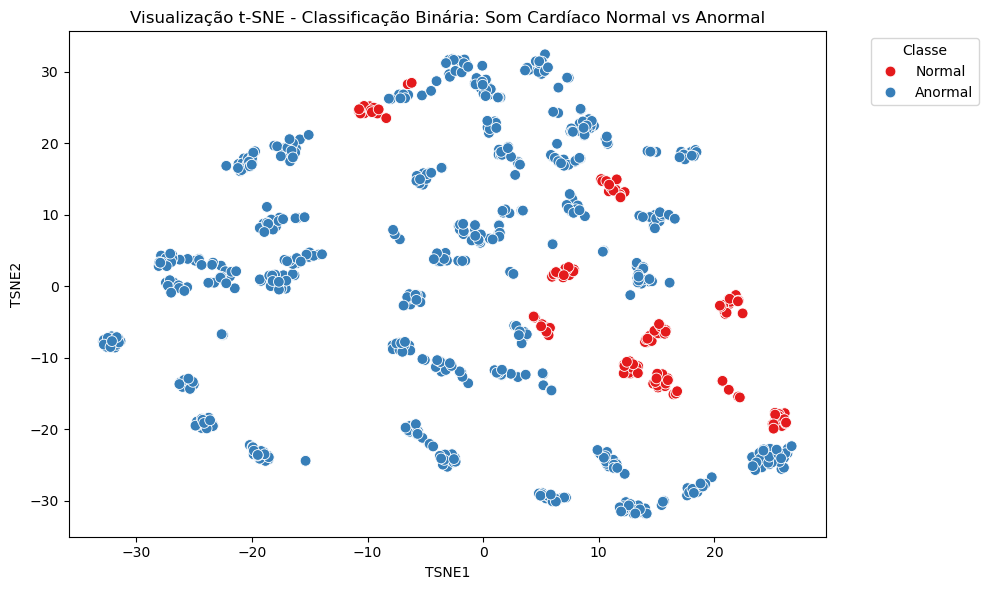

In [ ]:

df = df_agg_cod.copy()

X = df.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")

if "Heart_Sound_Type_Normal" in df.columns:
    df["label"] = df["Heart_Sound_Type_Normal"].map(
        {0: "Anormal", 1: "Normal"})
    y = df["label"]
else:
    raise ValueError("Coluna 'Heart_Sound_Type_Normal' não encontrada.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Redução de dimensionalidade com PCA antes do t-SNE
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df["TSNE1"] = X_tsne[:, 0]
df["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2",
                hue="label", palette="Set1", s=60)
plt.title(
    "Visualização t-SNE - Classificação Binária: Som Cardíaco Normal vs Anormal")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Importância das variáveis (com _RandomForest_)


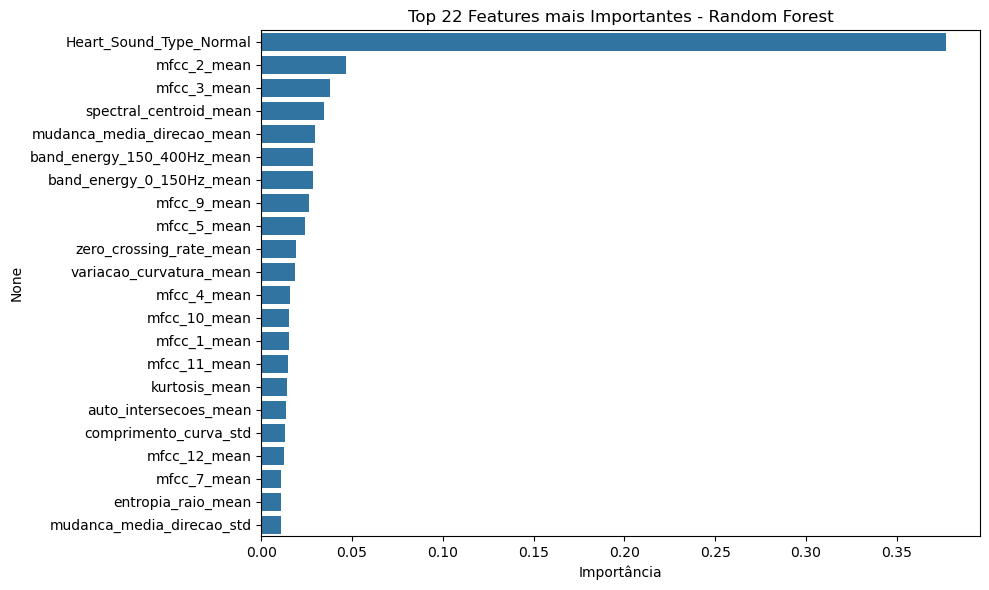

(Heart_Sound_Type_Normal       0.376936
 mfcc_2_mean                   0.046813
 mfcc_3_mean                   0.037787
 spectral_centroid_mean        0.034435
 mudanca_media_direcao_mean    0.029812
 band_energy_150_400Hz_mean    0.028557
 band_energy_0_150Hz_mean      0.028509
 mfcc_9_mean                   0.026265
 mfcc_5_mean                   0.024228
 zero_crossing_rate_mean       0.019437
 variacao_curvatura_mean       0.018848
 mfcc_4_mean                   0.015817
 mfcc_10_mean                  0.015329
 mfcc_1_mean                   0.015212
 mfcc_11_mean                  0.014969
 kurtosis_mean                 0.014463
 auto_intersecoes_mean         0.013810
 comprimento_curva_std         0.013305
 mfcc_12_mean                  0.012612
 mfcc_7_mean                   0.011152
 entropia_raio_mean            0.010884
 mudanca_media_direcao_std     0.010785
 dtype: float64,
 {'mfcc_2_mean': np.float64(1.3192790481593503e-24),
  'spectral_centroid_mean': np.float64(1.220373723

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False).head(22)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.values, y=importances_sorted.index)
plt.title("Top 22 Features mais Importantes - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

importances_sorted, anova_binaria_sorted

### ViolinPlots dos top 5 MFCCs entre 2-3 classes mais distintas

D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

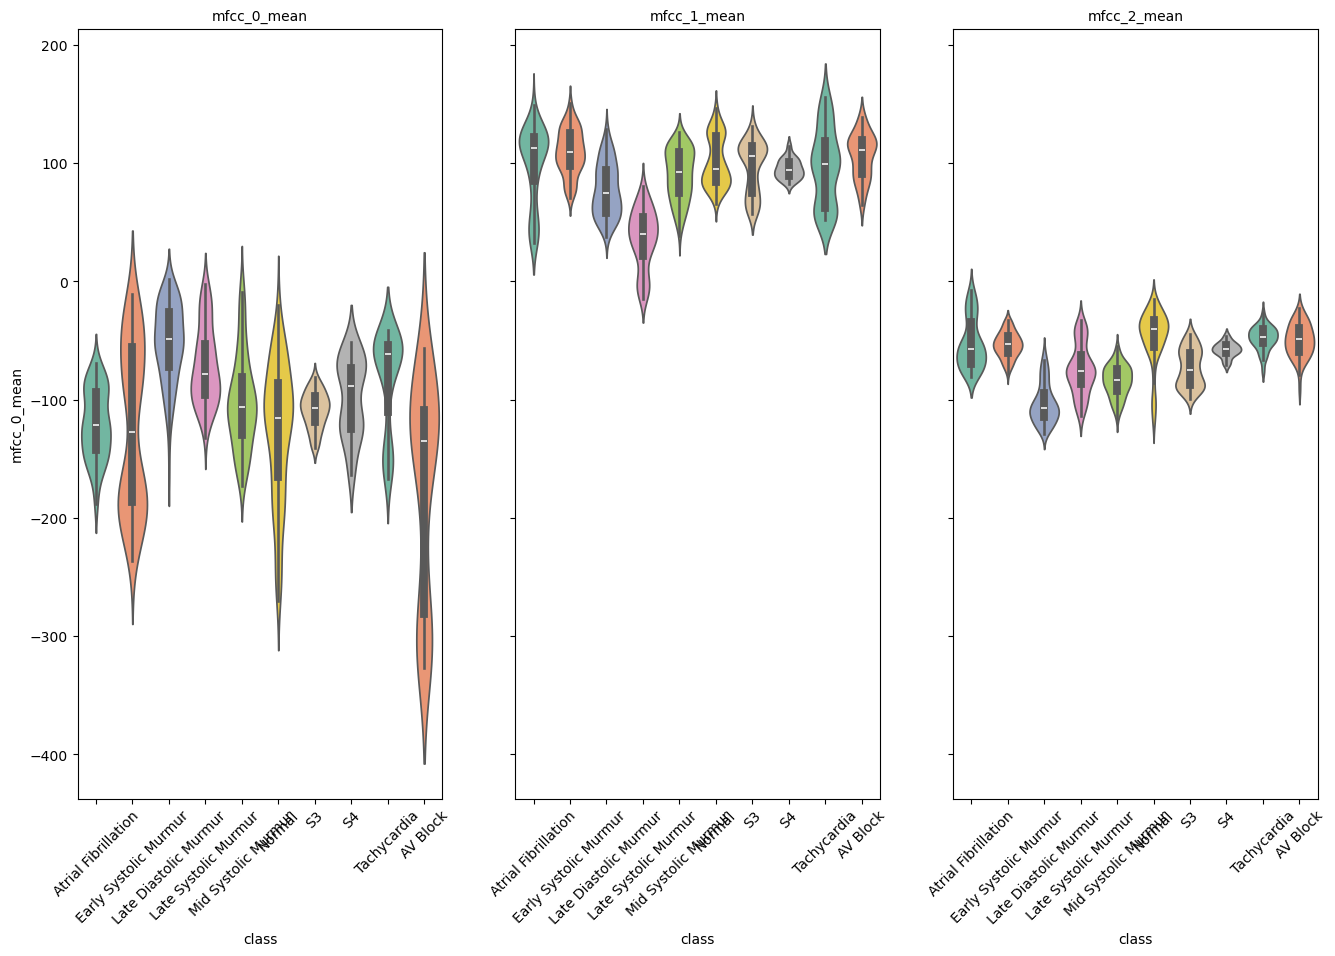

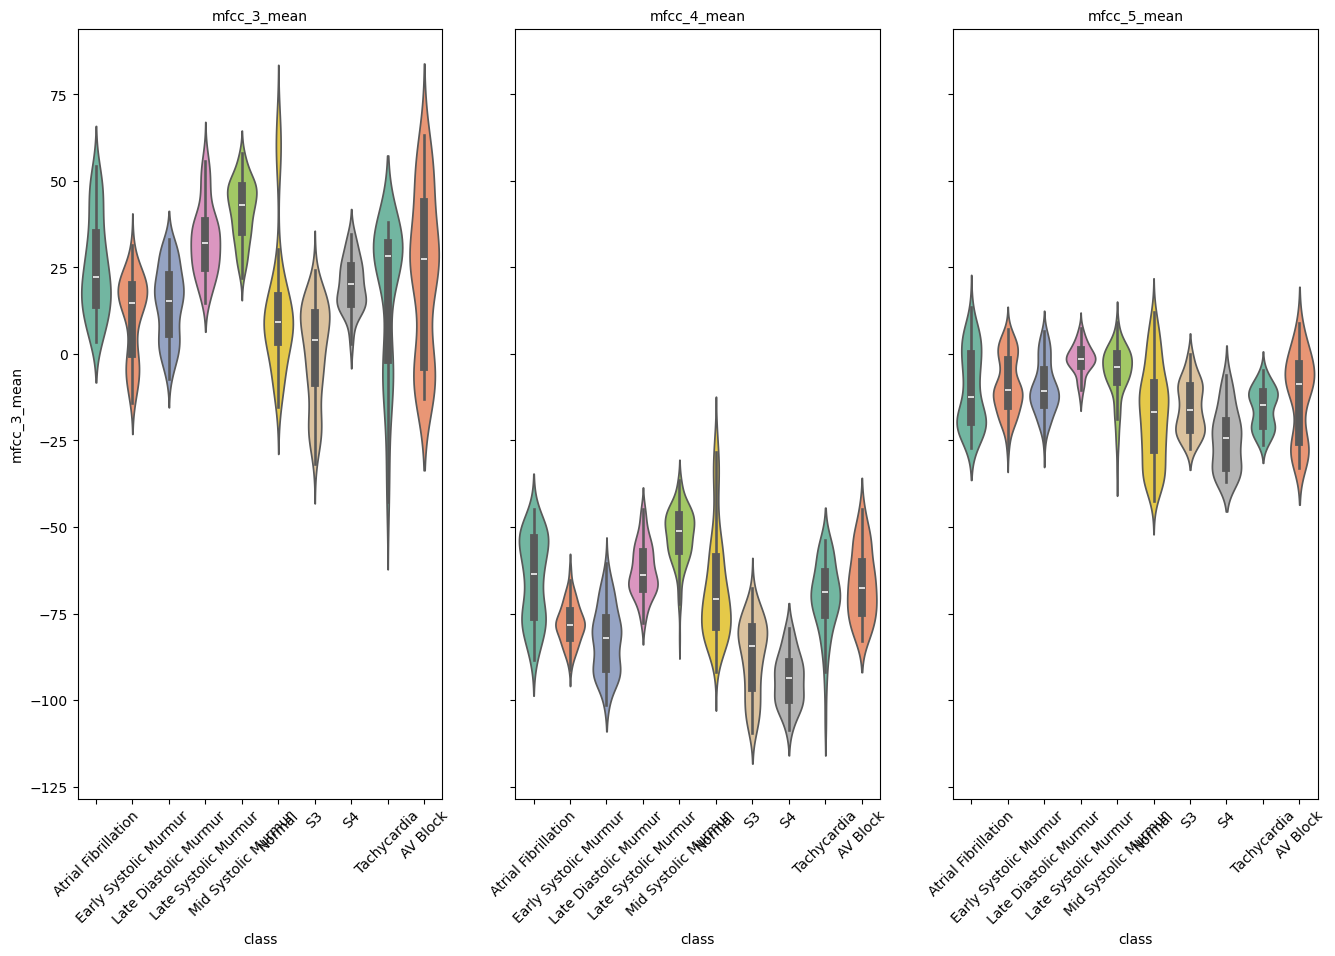

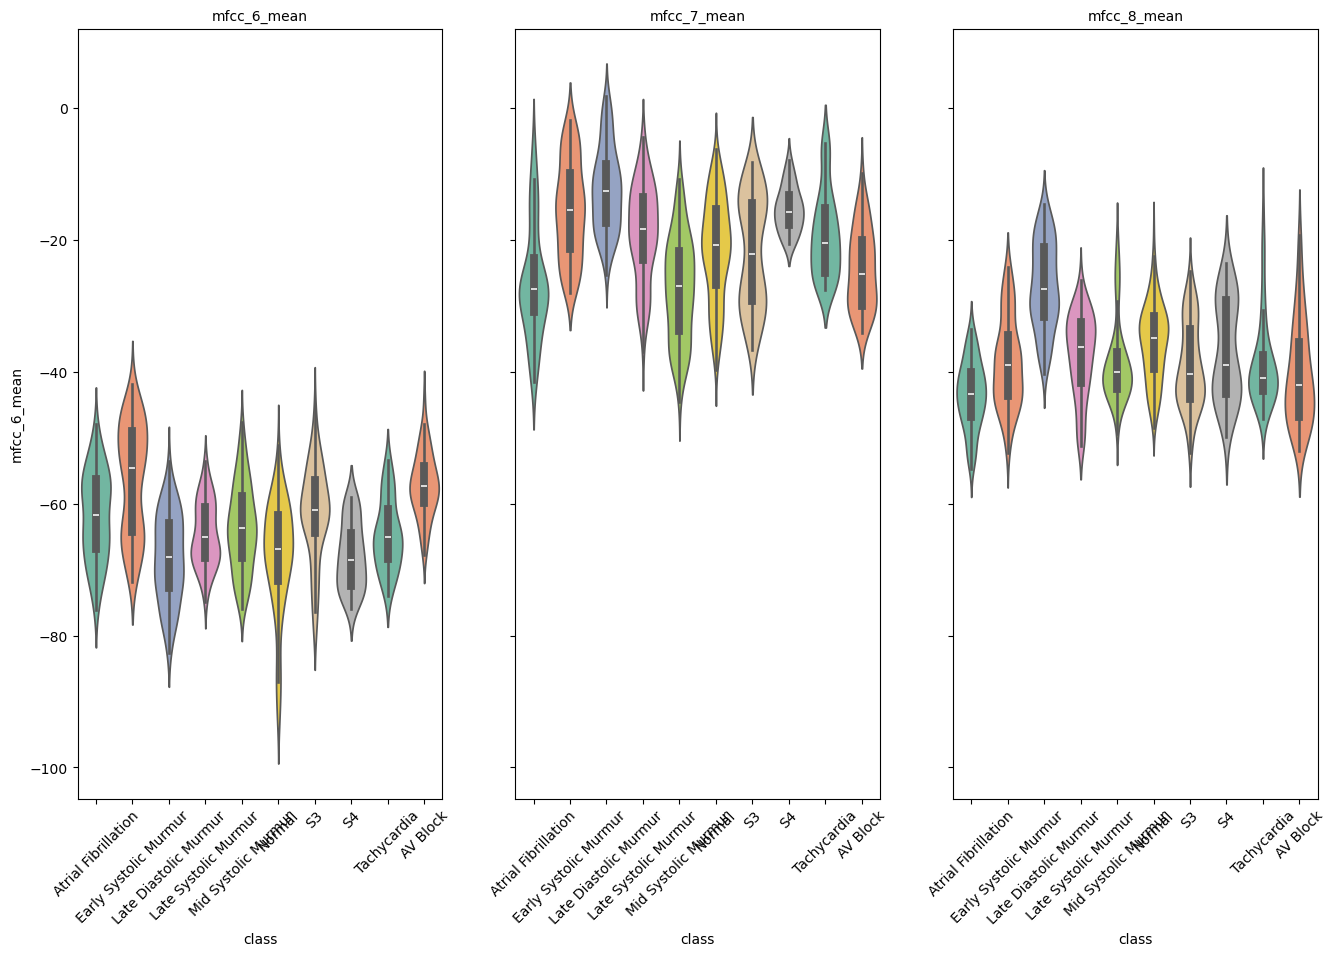

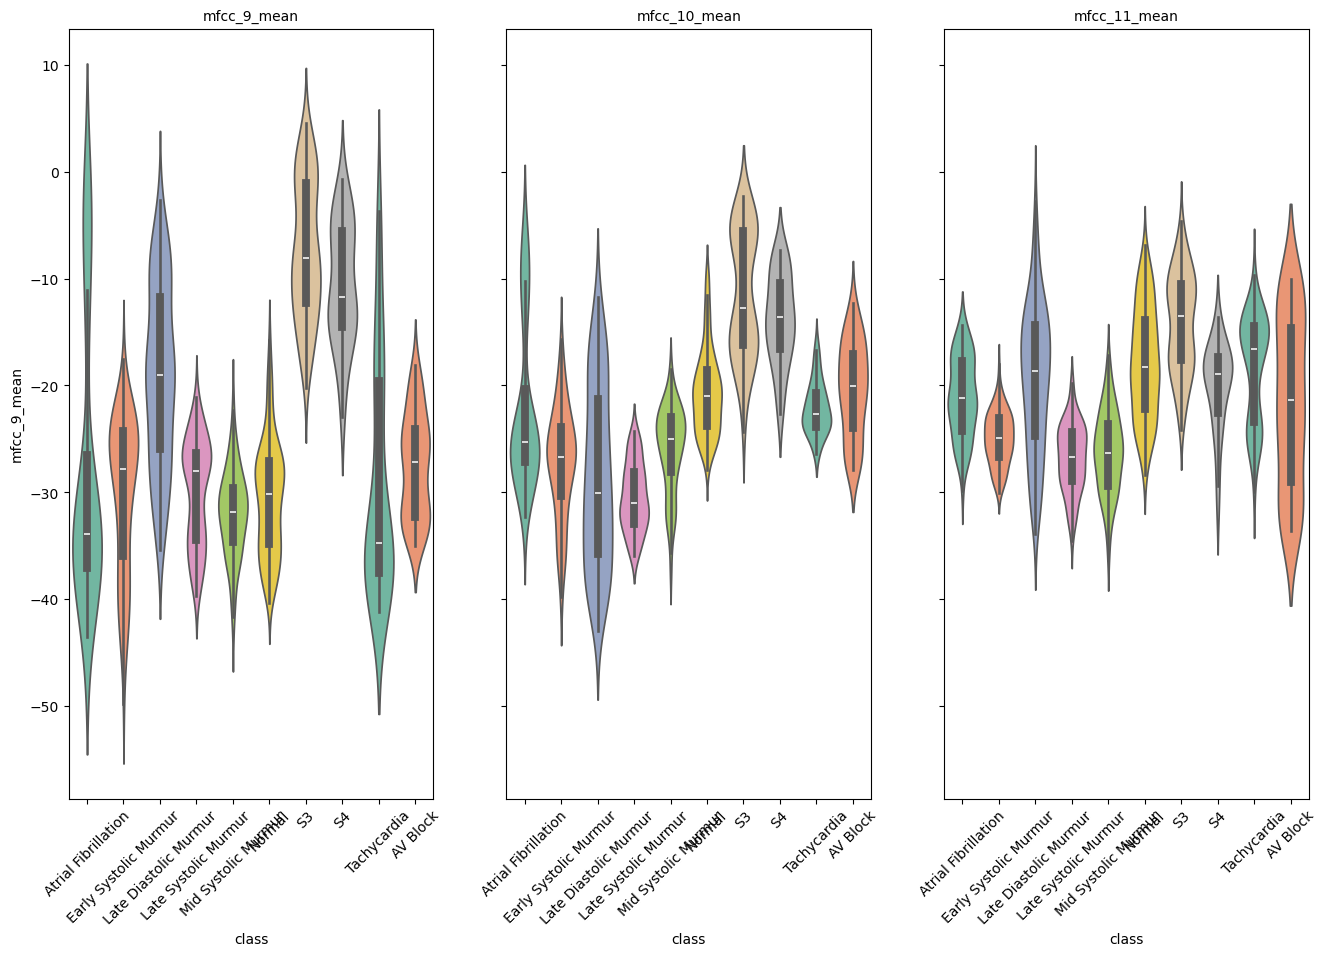

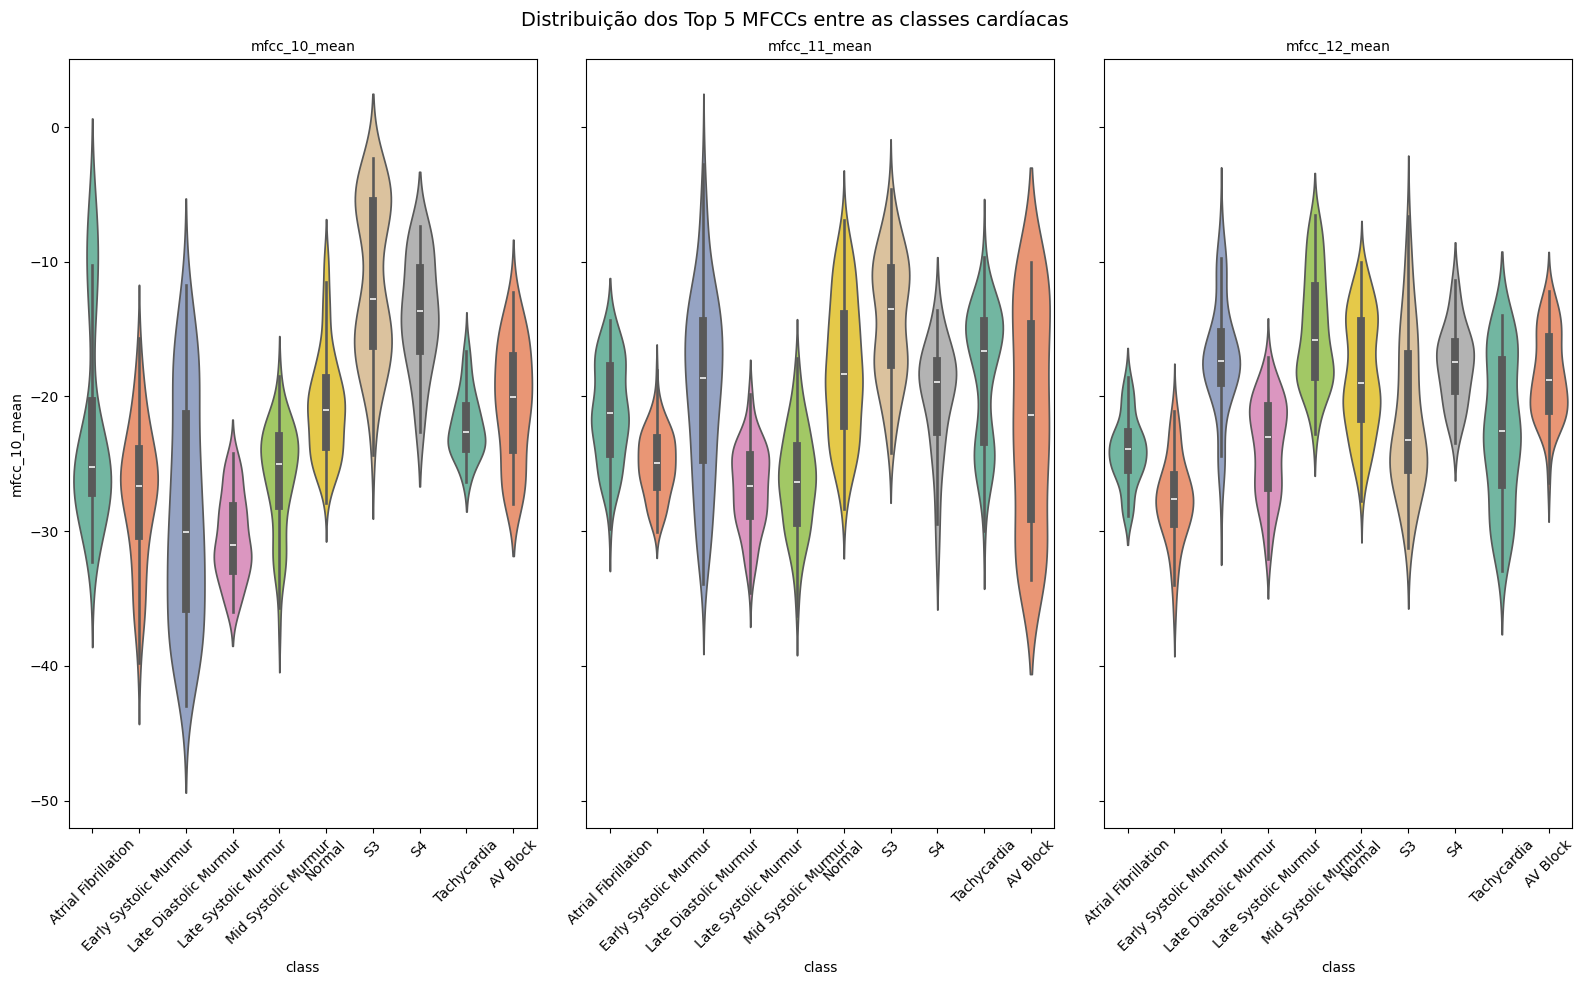

In [48]:

# Selecionar os top 5 MFCCs com base nos resultados de ANOVA anteriores
top_mfccs = ['mfcc_0_mean', 'mfcc_1_mean',
              'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
              'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean',
              'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
              'mfcc_11_mean', 'mfcc_12_mean']

# Nome da coluna de rótulo de classe
label_col = 'Heart Sound Type'  # nome comum antes da codificação one-hot

# Extração do nome da classe com one-hot encoding reversa
df['class'] = df.filter(like='Heart Sound Type_').idxmax(
    axis=1).str.replace('Heart Sound Type_', '')

# Plotar violinplots dos MFCCs

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[:3]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[3:6]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[6:9]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[9:12]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[10:]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)


# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)
# for i, mfcc in enumerate(top_mfccs[9:12]):
#     sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],)
#     axs[i].set_title(mfcc, fontsize=10)
#     axs[i].tick_params(axis='x', rotation=45)


fig.suptitle(
    'Distribuição dos Top 5 MFCCs entre as classes cardíacas', fontsize=14)
plt.tight_layout()
plt.show()

D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

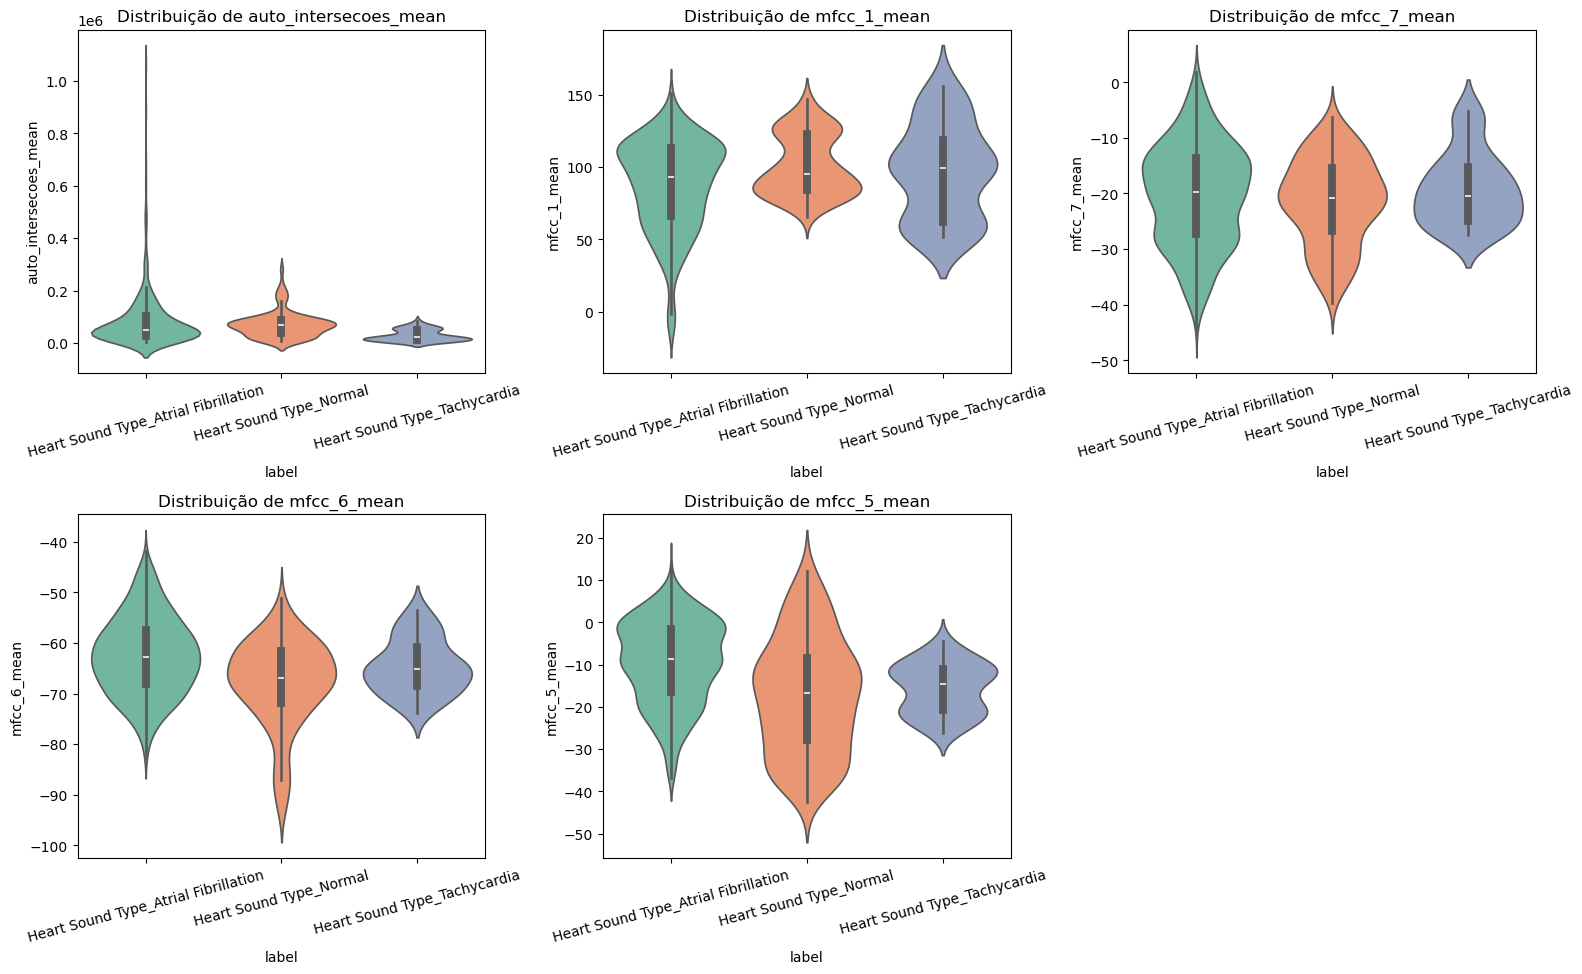

In [ ]:

df = df_agg_cod.copy()

# Determinar os top 5 MFCCs a partir dos resultados do ANOVA
top_mfccs = ['mfcc_3_mean', 'mfcc_1_mean',
             'mfcc_7_mean', 'mfcc_6_mean', 'mfcc_5_mean']

# Selecionar apenas classes de interesse (AFib, Normal, e uma terceira distinta)
classes_selecionadas = [
    'Heart Sound Type_Atrial Fibrillation',
    'Heart Sound Type_Normal',
    'Heart Sound Type_Tachycardia'
]

# Adicionar coluna de rótulo unificado
df["label"] = df[classes_selecionadas].idxmax(axis=1)

# Gerar os violinplots
plt.figure(figsize=(16, 10))
for i, col in enumerate(top_mfccs, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df, x="label", y=col, palette="Set2")
    plt.title(f"Distribuição de {col}")
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()